# 1. Генерація датасету та робота з лінійною регресією

In [2]:
from google.colab import files
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.datasets import make_friedman1
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from google.colab import drive
import numpy as np

# 1.1 Генерація датасету


In [3]:
X, y = make_friedman1(n_samples=150000, n_features=10, noise=0.8, random_state=20040525)
X

array([[0.91813579, 0.25042029, 0.35429111, ..., 0.37923408, 0.81500396,
        0.93873159],
       [0.70435259, 0.82893435, 0.30458949, ..., 0.43520028, 0.53990979,
        0.33658519],
       [0.66423466, 0.42389996, 0.19941668, ..., 0.26509286, 0.83903536,
        0.924552  ],
       ...,
       [0.35302509, 0.43575046, 0.08217516, ..., 0.32036005, 0.81688313,
        0.13690955],
       [0.11501528, 0.86699322, 0.02676679, ..., 0.12402033, 0.40659469,
        0.10525972],
       [0.36234129, 0.96308285, 0.67845079, ..., 0.165857  , 0.72565859,
        0.56580967]])

In [4]:
y = y.reshape(-1, 1)
y

array([[ 9.22149398],
       [19.5455195 ],
       [22.67514277],
       ...,
       [18.14330851],
       [18.57923443],
       [20.87578411]])

# 1.2 Розбиття даних на навчальні та валідаційні та навчання моделі

##### Розіб'ємо отримані дані на навчальні та валідаційні за допомогою функції sklearn.train_test_split та застособуємо лінійну регресію для навчання моделі на тренувальних даних

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3, random_state=20040525)
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

##### Для навченої моделі обрахуємо метрики квадратичної і абсолютної похибок та R2 score на навчальних та валідаційних даних

In [6]:
baseline_mse_traine = mean_squared_error(y_train, lr.predict(X_train))
baseline_mse = mean_squared_error(y_test, lr.predict(X_test))
r2_score_train = r2_score(y_train, lr.predict(X_train))
r2_score_test = r2_score(y_test, lr.predict(X_test))
baseline_mape_train = mean_absolute_percentage_error(y_train, lr.predict(X_train))
baseline_mape_test = mean_absolute_percentage_error(y_test, lr.predict(X_test))

print("R2 accurancy score for train:", r2_score_train)
print("R2 accurancy score for test:", r2_score_test)
print("Baseline MAPE for train:", baseline_mape_train)
print("Baseline MAPE for test:", baseline_mape_test)
print("Baseline MSE for train:", baseline_mse_traine)
print("Baseline MSE for test:", baseline_mse)

R2 accurancy score for train: 0.7355197255400873
R2 accurancy score for test: 0.7333534025952324
Baseline MAPE for train: 0.1685797582243309
Baseline MAPE for test: 0.16953726101476407
Baseline MSE for train: 6.446364638992084
Baseline MSE for test: 6.529761746821899


##### Бачимо, що для лінійної ргересії метрика R2 точності передбачення рівна 0.73 що не надто хороший результат, що пов'язано із тим що дані згенеровані функцією make_friedman1 є розподілені нелінійно, через що їх важко описати лінійною регресією. Якби ми застосовували не нейронні мережі, а звичайне машинне навчання то можна було б розглядати інші види регресій, які краще описують дані.

Виведимо значення коефіцієтів моделі та її доданок b

In [7]:
lr.coef_

array([[ 6.73975442e+00,  6.70903217e+00,  2.11039390e-02,
         1.00197460e+01,  4.99893354e+00,  5.70529691e-03,
        -2.74836223e-02, -2.35411360e-02,  1.19728599e-02,
        -4.78386507e-02]])

In [8]:
lr.intercept_

array([0.21167312])

Візуалізуємо криві, які описують R2 оцінку моделі на навчальних і валідаційних даних

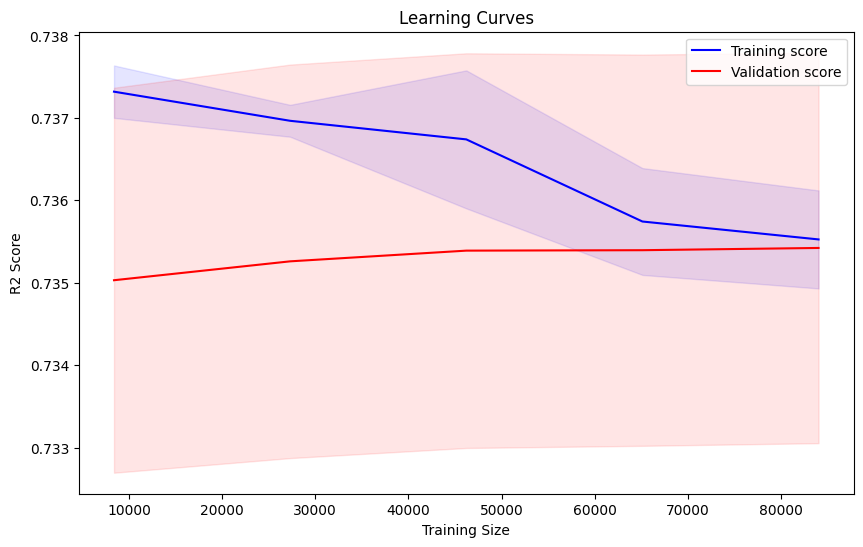

In [9]:
train_sizes, train_scores, test_scores = learning_curve(lr, X_train, y_train, cv=5)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', color='blue')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, label='Validation score', color='red')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='red')
plt.title('Learning Curves')
plt.xlabel('Training Size')
plt.ylabel('R2 Score')
plt.legend(loc='best')
plt.show()

# 2. Створення, навчання/валідація, візуалізація нейронної мережі DNN при різних гіперпараметрах

Створимо модель нейронної мережі застосувавши функцію активації ReLu, а також для прихованих шарів застосуємо BatchNorm1d для стандартизації та нормалізації batch значень мережі, що допоможе пришвидшити навчання мережі та запобігатими перенавчанню

In [10]:
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(DNN, self).__init__()
        self.num_layers = num_layers
        self.layers = []
        self.layers.append(nn.Linear(input_size, hidden_size, bias=True))
        self.layers.append(nn.BatchNorm1d(hidden_size))
        self.layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            self.layers.append(nn.Linear(hidden_size, hidden_size, bias=True))
            self.layers.append(nn.BatchNorm1d(hidden_size))
            self.layers.append(nn.ReLU())
        self.layers.append(nn.Linear(hidden_size, output_size, bias=True))
        self.model = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.model(x)


Створимо функцію що буде одночасно навчати і оцінювати результати навчання для кожної з епох моделі і збирати метрики MSE, MAPE, R2 для оцінки результатів роботи моделі на різних епохах та при різних параметрах, оптимізаторах і тд.
Відповідно будемо виводити проміжні результати навчання раз в 10 епох

In [14]:
def train_validate_model_dnn(model, optimizer, criterion, train_loader, val_loader, epochs=15):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    train_losses = []
    val_losses = []
    r2_train_scores = []
    r2_val_scores = []
    mape_train_scores = []
    mape_val_scores = []
    mse_train_losses = []
    mse_val_losses = []
    predictions_train = []
    predictions_val = []

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        predictions_train_epoch = []
        targets_train_all = []
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
            predictions_train_epoch.extend(outputs.detach().cpu().numpy())
            targets_train_all.extend(targets.detach().cpu().numpy())

        train_loss /= len(train_loader.dataset)
        train_losses.append(train_loss)
        r2_train_scores.append(r2_score(targets_train_all, predictions_train_epoch))
        predictions_train.append(predictions_train_epoch)
        mape_train_scores.append(mean_absolute_percentage_error(targets_train_all, predictions_train_epoch))
        mse_train_losses.append(mean_squared_error(targets_train_all, predictions_train_epoch))
        if epoch%5 == 0 or epoch == 0:
          print(f'Epoch {epoch+1}/{epochs}, \t    R2 Score (Train): {r2_train_scores[-1]:.4f},    MAPE (Train): {mape_train_scores[-1]:.4f},  \t    MSE (Train): {mse_train_losses[-1]:.4f}')

        model.eval()
        val_loss = 0.0
        predictions_val_epoch = []
        targets_val_all = []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item() * inputs.size(0)
                predictions_val_epoch.extend(outputs.cpu().numpy())
                targets_val_all.extend(targets.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        r2_val_scores.append(r2_score(targets_val_all, predictions_val_epoch))
        predictions_val.append(predictions_val_epoch)
        mape_val_scores.append(mean_absolute_percentage_error(targets_val_all, predictions_val_epoch))
        mse_val_losses.append(mean_squared_error(targets_val_all, predictions_val_epoch))

        if epoch%10 == 0 or epoch == 0 or epoch==epochs:
          print(f'Epoch {epoch+1}/{epochs}, \t    R2 Score (Validation): {r2_val_scores[-1]:.4f},    MAPE (Validation): {mape_val_scores[-1]:.4f}, \t MSE    (Validation): {mse_val_losses[-1]:.4f}')

    return r2_train_scores, r2_val_scores, mape_train_scores, mape_val_scores, mse_train_losses, mse_val_losses, predictions_train, predictions_val


Тепер після того як всі потрібні параметри для роботи DNN мережі створені та підготовлені до навчання та оцінки, згенеровані раніше дані потрібно перетворити в тензори аби мережа могла навчатися на них, та загружати їх по певній кількості(batch_size).

In [11]:
batch_size = 128
X_train_tensor = torch.Tensor(X_train).float()
y_train_tensor = torch.Tensor(y_train).float()
X_test_tensor = torch.Tensor(X_test).float()
y_test_tensor = torch.Tensor(y_test).float()

train_dataset =  torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

Тепер створимо безпосердньо моделі мереж і задамо параметри для них, так оскльки в нас регресійна задача виходом мережі мусить бути одне єдине значення тому output шар повинен містити 1 значення, а на вхід в свою чергу подається 10 параметрів. Для кожного значення кількості шарів в мережі (1, 5, 25) задамо сталу кількість нейронів, а саме 21. Епох навчання поставимо 80, та аби пришвидшити навчання мережі запустимо його через CUDA для відеокарт NVIDIA.

In [12]:
layers_sizes = [1, 5, 25]
learning_rates = [0.1, 0.01, 0.001]
input_layer_size = 10
output_layer_size = 1
neyrons_amount = 21
epochs = 80

Під час роботи з кожною моделлю виведимо графіки оцінок похибок, точності передбачення результатів мережою:

Epoch 1/80, 	    R2 Score (Train): 0.5429,    MAPE (Train): 0.2350,  	    MSE (Train): 11.1421
Epoch 1/80, 	    R2 Score (Validation): 0.5672,    MAPE (Validation): 0.2320, 	 MSE    (Validation): 10.5998
Epoch 6/80, 	    R2 Score (Train): 0.5876,    MAPE (Train): 0.2323,  	    MSE (Train): 10.0519
Epoch 11/80, 	    R2 Score (Train): 0.5945,    MAPE (Train): 0.2305,  	    MSE (Train): 9.8831
Epoch 11/80, 	    R2 Score (Validation): 0.6161,    MAPE (Validation): 0.2358, 	 MSE    (Validation): 9.4002
Epoch 16/80, 	    R2 Score (Train): 0.6015,    MAPE (Train): 0.2292,  	    MSE (Train): 9.7118
Epoch 21/80, 	    R2 Score (Train): 0.5973,    MAPE (Train): 0.2290,  	    MSE (Train): 9.8142
Epoch 21/80, 	    R2 Score (Validation): 0.7739,    MAPE (Validation): 0.1961, 	 MSE    (Validation): 5.5360
Epoch 26/80, 	    R2 Score (Train): 0.5886,    MAPE (Train): 0.2325,  	    MSE (Train): 10.0262
Epoch 31/80, 	    R2 Score (Train): 0.5998,    MAPE (Train): 0.2311,  	    MSE (Train): 9.7553
Epoch 3

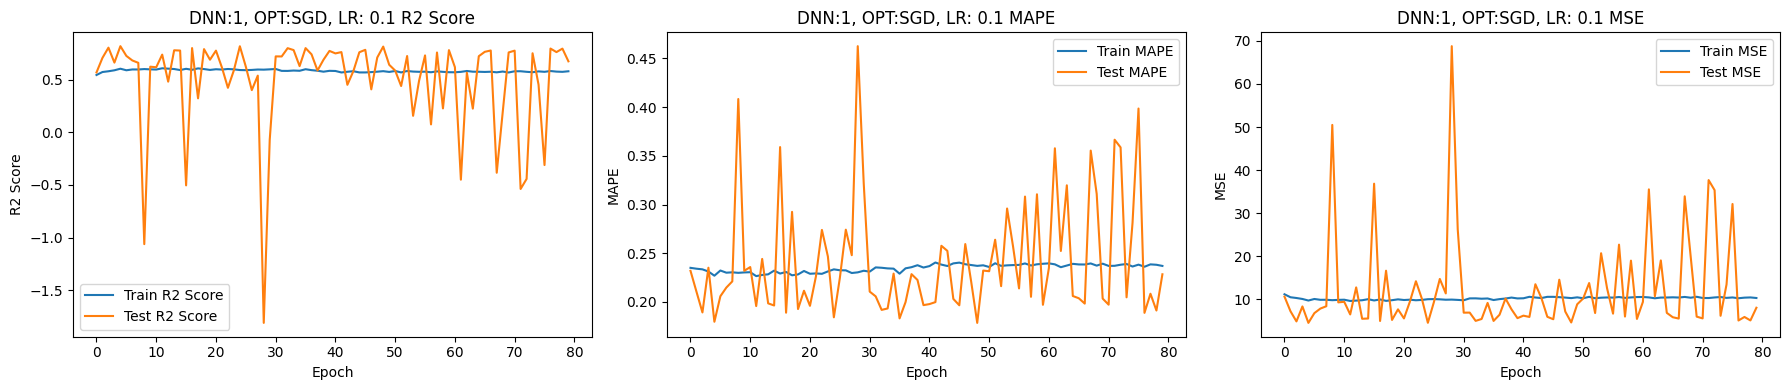

Epoch 1/80, 	    R2 Score (Train): 0.7359,    MAPE (Train): 0.1588,  	    MSE (Train): 6.4360
Epoch 1/80, 	    R2 Score (Validation): 0.8121,    MAPE (Validation): 0.1390, 	 MSE    (Validation): 4.6026
Epoch 6/80, 	    R2 Score (Train): 0.9336,    MAPE (Train): 0.0860,  	    MSE (Train): 1.6177
Epoch 11/80, 	    R2 Score (Train): 0.9358,    MAPE (Train): 0.0840,  	    MSE (Train): 1.5638
Epoch 11/80, 	    R2 Score (Validation): 0.9541,    MAPE (Validation): 0.0713, 	 MSE    (Validation): 1.1248
Epoch 16/80, 	    R2 Score (Train): 0.9365,    MAPE (Train): 0.0837,  	    MSE (Train): 1.5489
Epoch 21/80, 	    R2 Score (Train): 0.9371,    MAPE (Train): 0.0828,  	    MSE (Train): 1.5321
Epoch 21/80, 	    R2 Score (Validation): 0.9564,    MAPE (Validation): 0.0691, 	 MSE    (Validation): 1.0666
Epoch 26/80, 	    R2 Score (Train): 0.9433,    MAPE (Train): 0.0784,  	    MSE (Train): 1.3830
Epoch 31/80, 	    R2 Score (Train): 0.9459,    MAPE (Train): 0.0774,  	    MSE (Train): 1.3189
Epoch 31/80

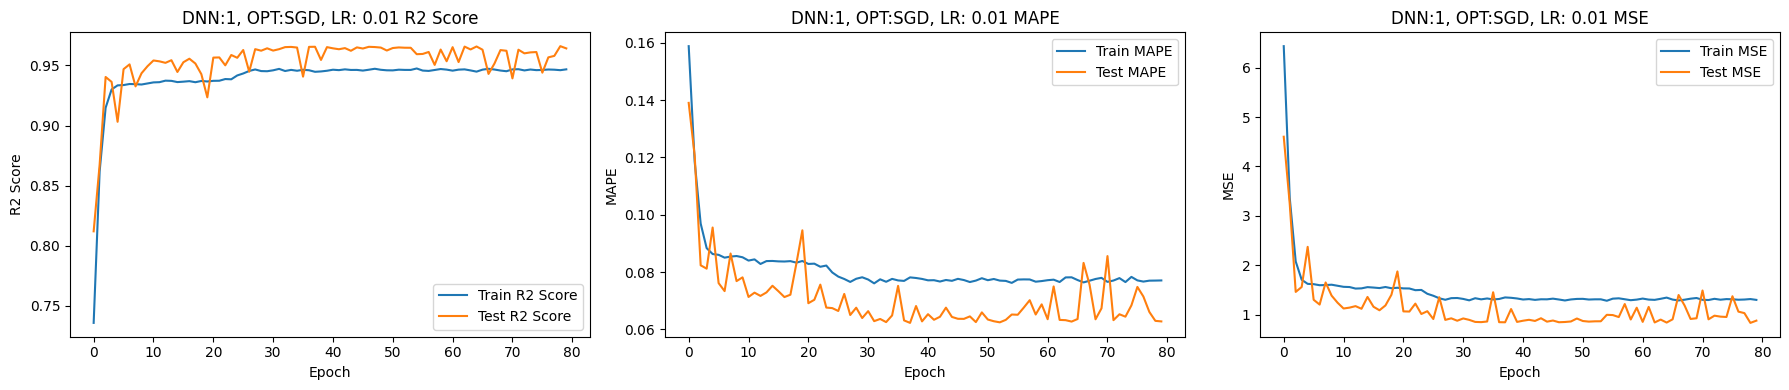

Epoch 1/80, 	    R2 Score (Train): 0.2812,    MAPE (Train): 0.2216,  	    MSE (Train): 17.5197
Epoch 1/80, 	    R2 Score (Validation): 0.7723,    MAPE (Validation): 0.1600, 	 MSE    (Validation): 5.5759
Epoch 6/80, 	    R2 Score (Train): 0.7993,    MAPE (Train): 0.1486,  	    MSE (Train): 4.8924
Epoch 11/80, 	    R2 Score (Train): 0.8085,    MAPE (Train): 0.1439,  	    MSE (Train): 4.6683
Epoch 11/80, 	    R2 Score (Validation): 0.8145,    MAPE (Validation): 0.1388, 	 MSE    (Validation): 4.5434
Epoch 16/80, 	    R2 Score (Train): 0.8124,    MAPE (Train): 0.1409,  	    MSE (Train): 4.5733
Epoch 21/80, 	    R2 Score (Train): 0.8125,    MAPE (Train): 0.1401,  	    MSE (Train): 4.5694
Epoch 21/80, 	    R2 Score (Validation): 0.8188,    MAPE (Validation): 0.1359, 	 MSE    (Validation): 4.4379
Epoch 26/80, 	    R2 Score (Train): 0.8139,    MAPE (Train): 0.1393,  	    MSE (Train): 4.5360
Epoch 31/80, 	    R2 Score (Train): 0.8136,    MAPE (Train): 0.1391,  	    MSE (Train): 4.5435
Epoch 31/8

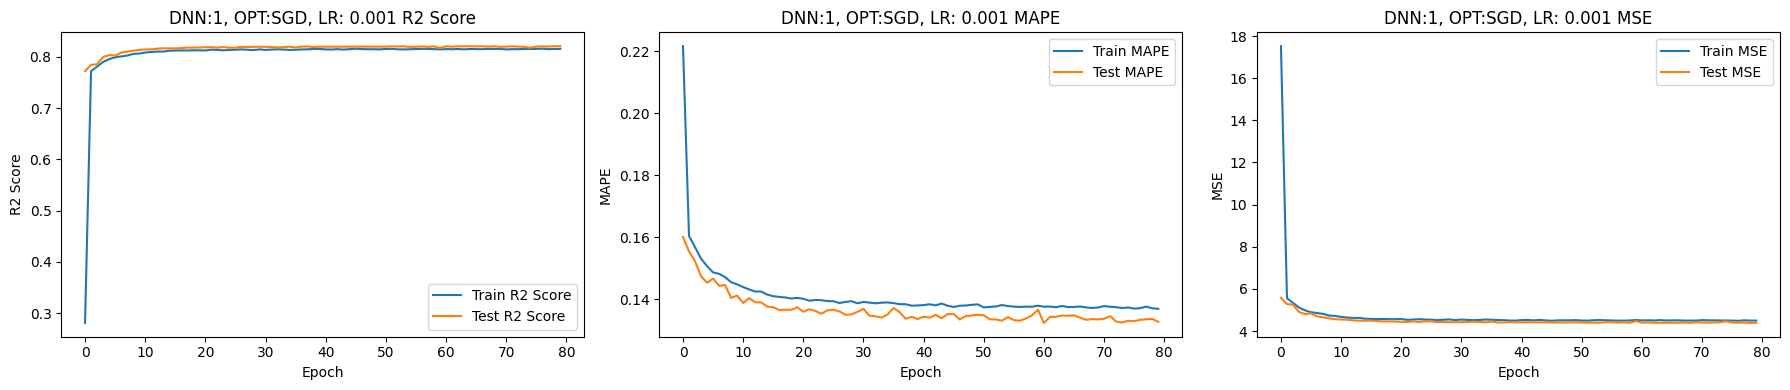

Epoch 1/80, 	    R2 Score (Train): 0.6188,    MAPE (Train): 0.1964,  	    MSE (Train): 9.2925
Epoch 1/80, 	    R2 Score (Validation): 0.9309,    MAPE (Validation): 0.1092, 	 MSE    (Validation): 1.6921
Epoch 6/80, 	    R2 Score (Train): 0.9262,    MAPE (Train): 0.0936,  	    MSE (Train): 1.7977
Epoch 11/80, 	    R2 Score (Train): 0.9297,    MAPE (Train): 0.0924,  	    MSE (Train): 1.7126
Epoch 11/80, 	    R2 Score (Validation): 0.9621,    MAPE (Validation): 0.0751, 	 MSE    (Validation): 0.9288
Epoch 16/80, 	    R2 Score (Train): 0.9321,    MAPE (Train): 0.0904,  	    MSE (Train): 1.6546
Epoch 21/80, 	    R2 Score (Train): 0.9314,    MAPE (Train): 0.0901,  	    MSE (Train): 1.6718
Epoch 21/80, 	    R2 Score (Validation): 0.9586,    MAPE (Validation): 0.0664, 	 MSE    (Validation): 1.0139
Epoch 26/80, 	    R2 Score (Train): 0.9334,    MAPE (Train): 0.0892,  	    MSE (Train): 1.6242
Epoch 31/80, 	    R2 Score (Train): 0.9358,    MAPE (Train): 0.0870,  	    MSE (Train): 1.5651
Epoch 31/80

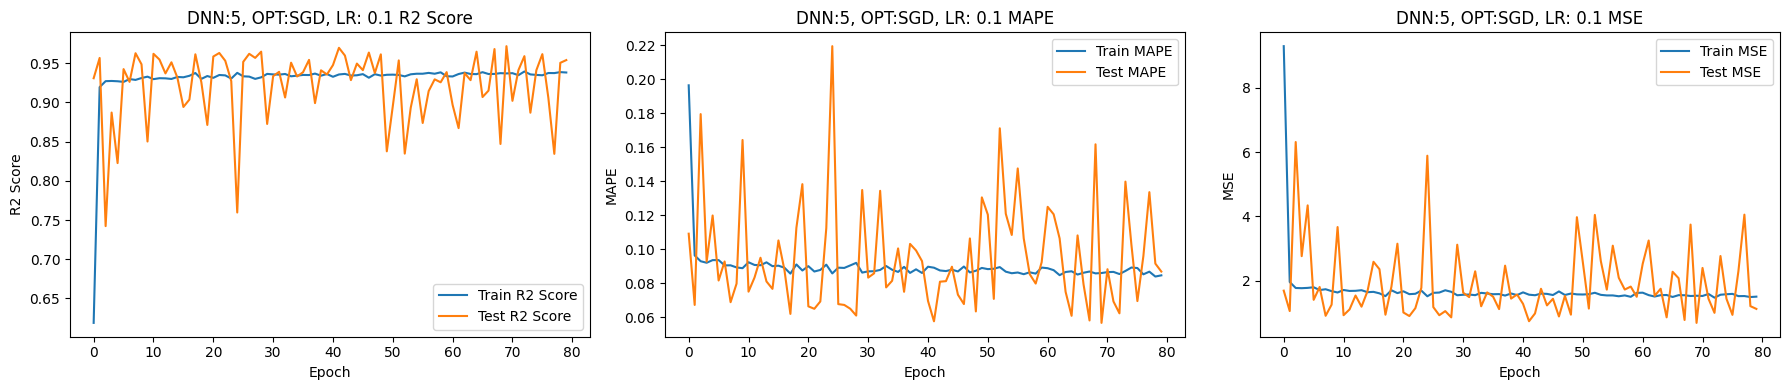

Epoch 1/80, 	    R2 Score (Train): 0.8539,    MAPE (Train): 0.1064,  	    MSE (Train): 3.5601
Epoch 1/80, 	    R2 Score (Validation): 0.9427,    MAPE (Validation): 0.0762, 	 MSE    (Validation): 1.4038
Epoch 6/80, 	    R2 Score (Train): 0.9475,    MAPE (Train): 0.0773,  	    MSE (Train): 1.2791
Epoch 11/80, 	    R2 Score (Train): 0.9503,    MAPE (Train): 0.0753,  	    MSE (Train): 1.2106
Epoch 11/80, 	    R2 Score (Validation): 0.9678,    MAPE (Validation): 0.0624, 	 MSE    (Validation): 0.7881
Epoch 16/80, 	    R2 Score (Train): 0.9521,    MAPE (Train): 0.0743,  	    MSE (Train): 1.1665
Epoch 21/80, 	    R2 Score (Train): 0.9524,    MAPE (Train): 0.0741,  	    MSE (Train): 1.1591
Epoch 21/80, 	    R2 Score (Validation): 0.9669,    MAPE (Validation): 0.0636, 	 MSE    (Validation): 0.8095
Epoch 26/80, 	    R2 Score (Train): 0.9539,    MAPE (Train): 0.0732,  	    MSE (Train): 1.1241
Epoch 31/80, 	    R2 Score (Train): 0.9546,    MAPE (Train): 0.0729,  	    MSE (Train): 1.1062
Epoch 31/80

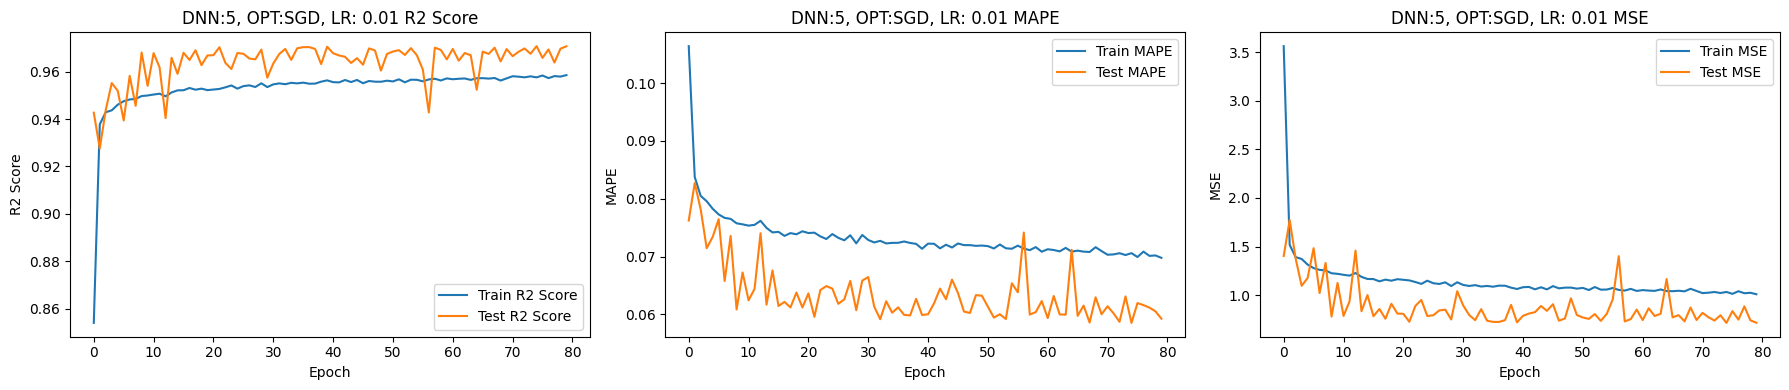

Epoch 1/80, 	    R2 Score (Train): 0.4243,    MAPE (Train): 0.1771,  	    MSE (Train): 14.0327
Epoch 1/80, 	    R2 Score (Validation): 0.9373,    MAPE (Validation): 0.0883, 	 MSE    (Validation): 1.5351
Epoch 6/80, 	    R2 Score (Train): 0.9430,    MAPE (Train): 0.0815,  	    MSE (Train): 1.3902
Epoch 11/80, 	    R2 Score (Train): 0.9471,    MAPE (Train): 0.0781,  	    MSE (Train): 1.2888
Epoch 11/80, 	    R2 Score (Validation): 0.9659,    MAPE (Validation): 0.0646, 	 MSE    (Validation): 0.8341
Epoch 16/80, 	    R2 Score (Train): 0.9493,    MAPE (Train): 0.0764,  	    MSE (Train): 1.2360
Epoch 21/80, 	    R2 Score (Train): 0.9515,    MAPE (Train): 0.0746,  	    MSE (Train): 1.1823
Epoch 21/80, 	    R2 Score (Validation): 0.9688,    MAPE (Validation): 0.0612, 	 MSE    (Validation): 0.7640
Epoch 26/80, 	    R2 Score (Train): 0.9520,    MAPE (Train): 0.0741,  	    MSE (Train): 1.1710
Epoch 31/80, 	    R2 Score (Train): 0.9540,    MAPE (Train): 0.0728,  	    MSE (Train): 1.1221
Epoch 31/8

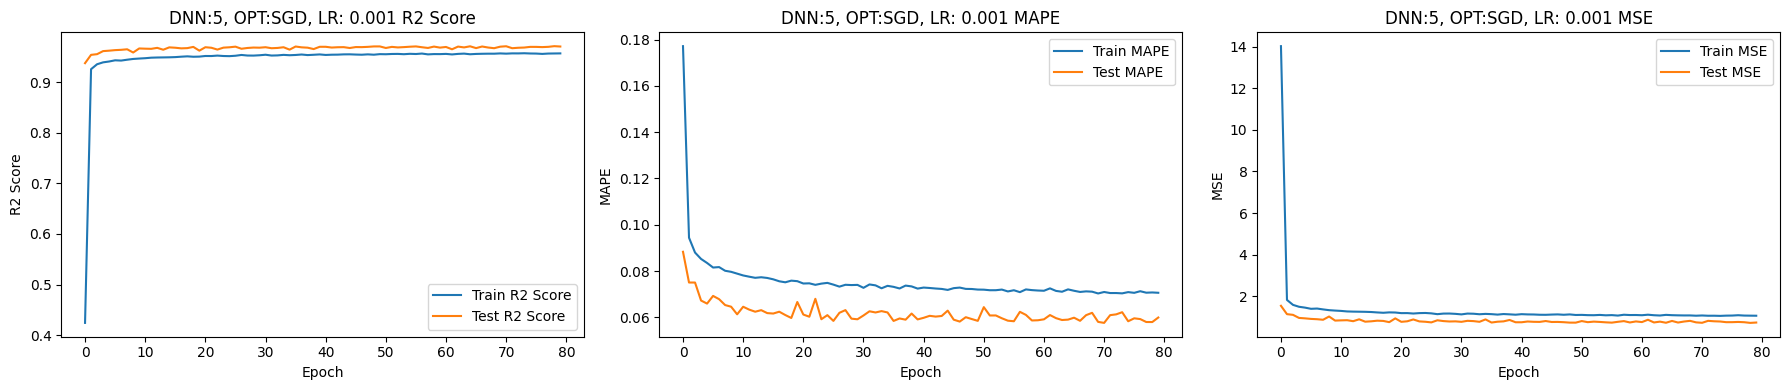

Epoch 1/80, 	    R2 Score (Train): 0.0230,    MAPE (Train): 0.3880,  	    MSE (Train): 23.8121
Epoch 1/80, 	    R2 Score (Validation): 0.4409,    MAPE (Validation): 0.2482, 	 MSE    (Validation): 13.6908
Epoch 6/80, 	    R2 Score (Train): 0.8538,    MAPE (Train): 0.1277,  	    MSE (Train): 3.5631
Epoch 11/80, 	    R2 Score (Train): 0.8980,    MAPE (Train): 0.1105,  	    MSE (Train): 2.4859
Epoch 11/80, 	    R2 Score (Validation): 0.7918,    MAPE (Validation): 0.1552, 	 MSE    (Validation): 5.0979
Epoch 16/80, 	    R2 Score (Train): 0.9087,    MAPE (Train): 0.1026,  	    MSE (Train): 2.2256
Epoch 21/80, 	    R2 Score (Train): 0.9189,    MAPE (Train): 0.0986,  	    MSE (Train): 1.9757
Epoch 21/80, 	    R2 Score (Validation): 0.7978,    MAPE (Validation): 0.1805, 	 MSE    (Validation): 4.9524
Epoch 26/80, 	    R2 Score (Train): 0.9227,    MAPE (Train): 0.0953,  	    MSE (Train): 1.8830
Epoch 31/80, 	    R2 Score (Train): 0.9255,    MAPE (Train): 0.0941,  	    MSE (Train): 1.8163
Epoch 31/

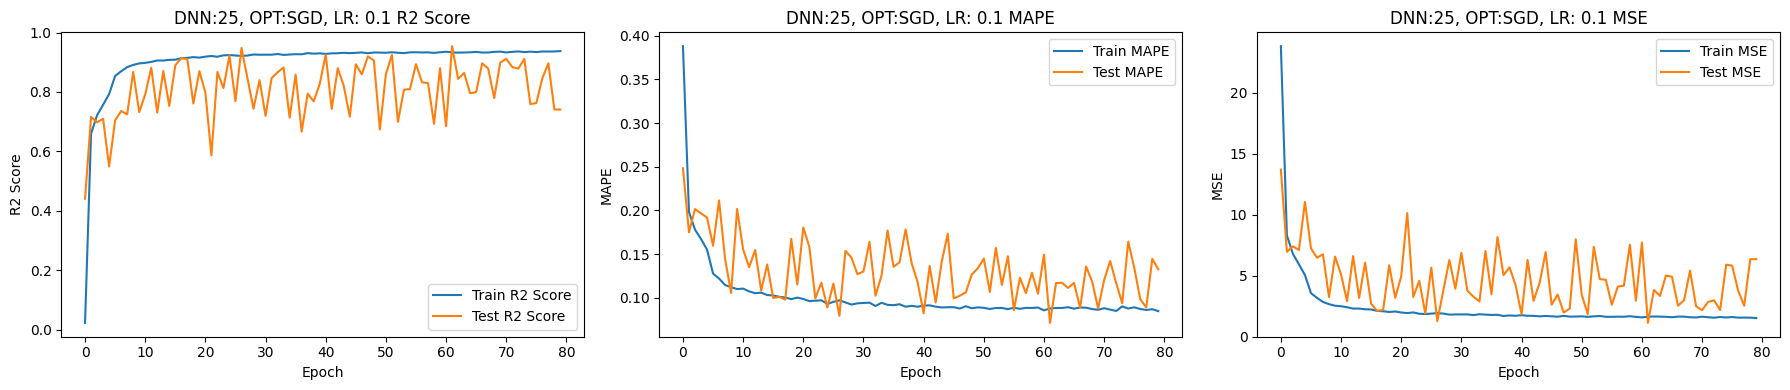

Epoch 1/80, 	    R2 Score (Train): 0.5766,    MAPE (Train): 0.2242,  	    MSE (Train): 10.3189
Epoch 1/80, 	    R2 Score (Validation): 0.7464,    MAPE (Validation): 0.1776, 	 MSE    (Validation): 6.2093
Epoch 6/80, 	    R2 Score (Train): 0.9265,    MAPE (Train): 0.0985,  	    MSE (Train): 1.7904
Epoch 11/80, 	    R2 Score (Train): 0.9353,    MAPE (Train): 0.0894,  	    MSE (Train): 1.5768
Epoch 11/80, 	    R2 Score (Validation): 0.8748,    MAPE (Validation): 0.1447, 	 MSE    (Validation): 3.0667
Epoch 16/80, 	    R2 Score (Train): 0.9325,    MAPE (Train): 0.0887,  	    MSE (Train): 1.6458
Epoch 21/80, 	    R2 Score (Train): 0.9414,    MAPE (Train): 0.0820,  	    MSE (Train): 1.4276
Epoch 21/80, 	    R2 Score (Validation): 0.9261,    MAPE (Validation): 0.1109, 	 MSE    (Validation): 1.8088
Epoch 26/80, 	    R2 Score (Train): 0.9424,    MAPE (Train): 0.0818,  	    MSE (Train): 1.4047
Epoch 31/80, 	    R2 Score (Train): 0.9452,    MAPE (Train): 0.0801,  	    MSE (Train): 1.3347
Epoch 31/8

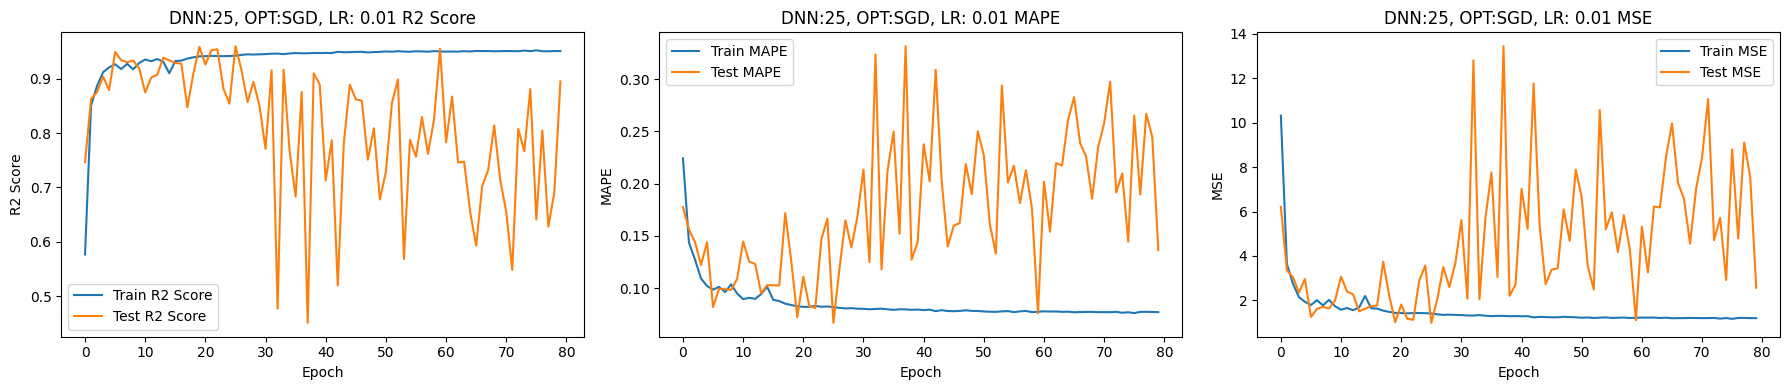

Epoch 1/80, 	    R2 Score (Train): 0.1594,    MAPE (Train): 0.2514,  	    MSE (Train): 20.4885
Epoch 1/80, 	    R2 Score (Validation): 0.7747,    MAPE (Validation): 0.1529, 	 MSE    (Validation): 5.5163
Epoch 6/80, 	    R2 Score (Train): 0.9117,    MAPE (Train): 0.1004,  	    MSE (Train): 2.1513
Epoch 11/80, 	    R2 Score (Train): 0.9154,    MAPE (Train): 0.0985,  	    MSE (Train): 2.0623
Epoch 11/80, 	    R2 Score (Validation): 0.9147,    MAPE (Validation): 0.1058, 	 MSE    (Validation): 2.0897
Epoch 16/80, 	    R2 Score (Train): 0.9303,    MAPE (Train): 0.0903,  	    MSE (Train): 1.6982
Epoch 21/80, 	    R2 Score (Train): 0.9324,    MAPE (Train): 0.0881,  	    MSE (Train): 1.6471
Epoch 21/80, 	    R2 Score (Validation): 0.9413,    MAPE (Validation): 0.0882, 	 MSE    (Validation): 1.4365
Epoch 26/80, 	    R2 Score (Train): 0.9365,    MAPE (Train): 0.0861,  	    MSE (Train): 1.5485
Epoch 31/80, 	    R2 Score (Train): 0.9353,    MAPE (Train): 0.0864,  	    MSE (Train): 1.5773
Epoch 31/8

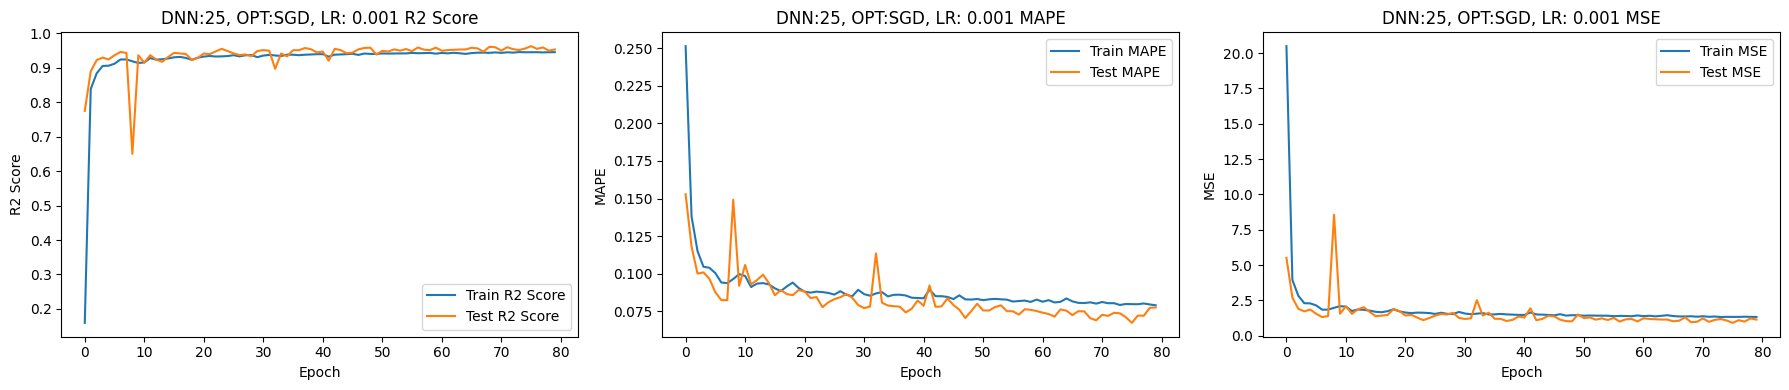

Epoch 1/80, 	    R2 Score (Train): 0.7170,    MAPE (Train): 0.1630,  	    MSE (Train): 6.8973
Epoch 1/80, 	    R2 Score (Validation): 0.7908,    MAPE (Validation): 0.1473, 	 MSE    (Validation): 5.1230
Epoch 6/80, 	    R2 Score (Train): 0.8421,    MAPE (Train): 0.1350,  	    MSE (Train): 3.8497
Epoch 11/80, 	    R2 Score (Train): 0.8414,    MAPE (Train): 0.1342,  	    MSE (Train): 3.8664
Epoch 11/80, 	    R2 Score (Validation): 0.8519,    MAPE (Validation): 0.1321, 	 MSE    (Validation): 3.6268
Epoch 16/80, 	    R2 Score (Train): 0.8423,    MAPE (Train): 0.1341,  	    MSE (Train): 3.8448
Epoch 21/80, 	    R2 Score (Train): 0.8430,    MAPE (Train): 0.1332,  	    MSE (Train): 3.8255
Epoch 21/80, 	    R2 Score (Validation): 0.8670,    MAPE (Validation): 0.1244, 	 MSE    (Validation): 3.2577
Epoch 26/80, 	    R2 Score (Train): 0.8415,    MAPE (Train): 0.1345,  	    MSE (Train): 3.8622
Epoch 31/80, 	    R2 Score (Train): 0.8426,    MAPE (Train): 0.1343,  	    MSE (Train): 3.8362
Epoch 31/80

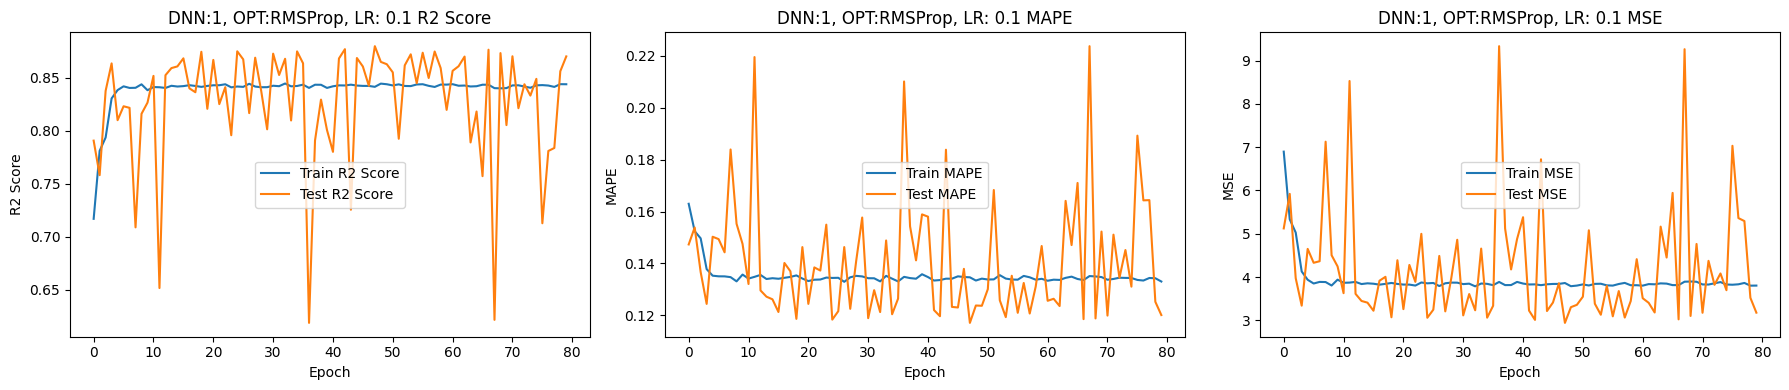

Epoch 1/80, 	    R2 Score (Train): 0.7233,    MAPE (Train): 0.1593,  	    MSE (Train): 6.7454
Epoch 1/80, 	    R2 Score (Validation): 0.7942,    MAPE (Validation): 0.1419, 	 MSE    (Validation): 5.0394
Epoch 6/80, 	    R2 Score (Train): 0.8119,    MAPE (Train): 0.1378,  	    MSE (Train): 4.5856
Epoch 11/80, 	    R2 Score (Train): 0.8117,    MAPE (Train): 0.1373,  	    MSE (Train): 4.5892
Epoch 11/80, 	    R2 Score (Validation): 0.7979,    MAPE (Validation): 0.1400, 	 MSE    (Validation): 4.9502
Epoch 16/80, 	    R2 Score (Train): 0.8896,    MAPE (Train): 0.1110,  	    MSE (Train): 2.6905
Epoch 21/80, 	    R2 Score (Train): 0.9351,    MAPE (Train): 0.0848,  	    MSE (Train): 1.5824
Epoch 21/80, 	    R2 Score (Validation): 0.9563,    MAPE (Validation): 0.0699, 	 MSE    (Validation): 1.0702
Epoch 26/80, 	    R2 Score (Train): 0.9374,    MAPE (Train): 0.0827,  	    MSE (Train): 1.5247
Epoch 31/80, 	    R2 Score (Train): 0.9373,    MAPE (Train): 0.0828,  	    MSE (Train): 1.5291
Epoch 31/80

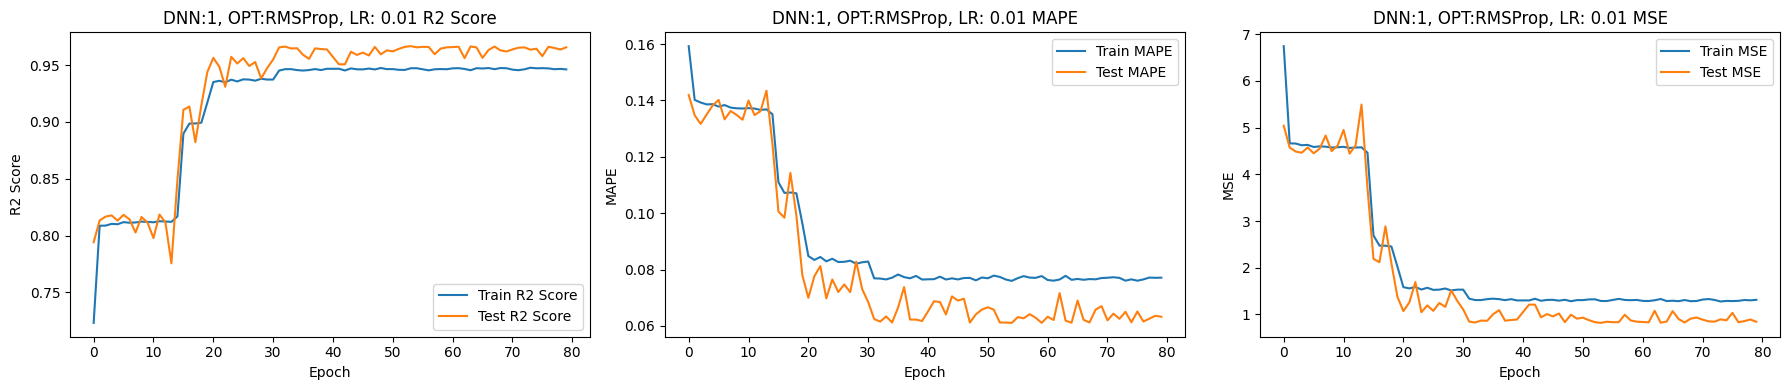

Epoch 1/80, 	    R2 Score (Train): -1.2343,    MAPE (Train): 0.4142,  	    MSE (Train): 54.4592
Epoch 1/80, 	    R2 Score (Validation): 0.7582,    MAPE (Validation): 0.1672, 	 MSE    (Validation): 5.9211
Epoch 6/80, 	    R2 Score (Train): 0.8083,    MAPE (Train): 0.1439,  	    MSE (Train): 4.6714
Epoch 11/80, 	    R2 Score (Train): 0.8127,    MAPE (Train): 0.1397,  	    MSE (Train): 4.5641
Epoch 11/80, 	    R2 Score (Validation): 0.8186,    MAPE (Validation): 0.1355, 	 MSE    (Validation): 4.4415
Epoch 16/80, 	    R2 Score (Train): 0.8148,    MAPE (Train): 0.1381,  	    MSE (Train): 4.5146
Epoch 21/80, 	    R2 Score (Train): 0.8142,    MAPE (Train): 0.1383,  	    MSE (Train): 4.5290
Epoch 21/80, 	    R2 Score (Validation): 0.8177,    MAPE (Validation): 0.1343, 	 MSE    (Validation): 4.4655
Epoch 26/80, 	    R2 Score (Train): 0.8148,    MAPE (Train): 0.1380,  	    MSE (Train): 4.5132
Epoch 31/80, 	    R2 Score (Train): 0.8156,    MAPE (Train): 0.1368,  	    MSE (Train): 4.4949
Epoch 31/

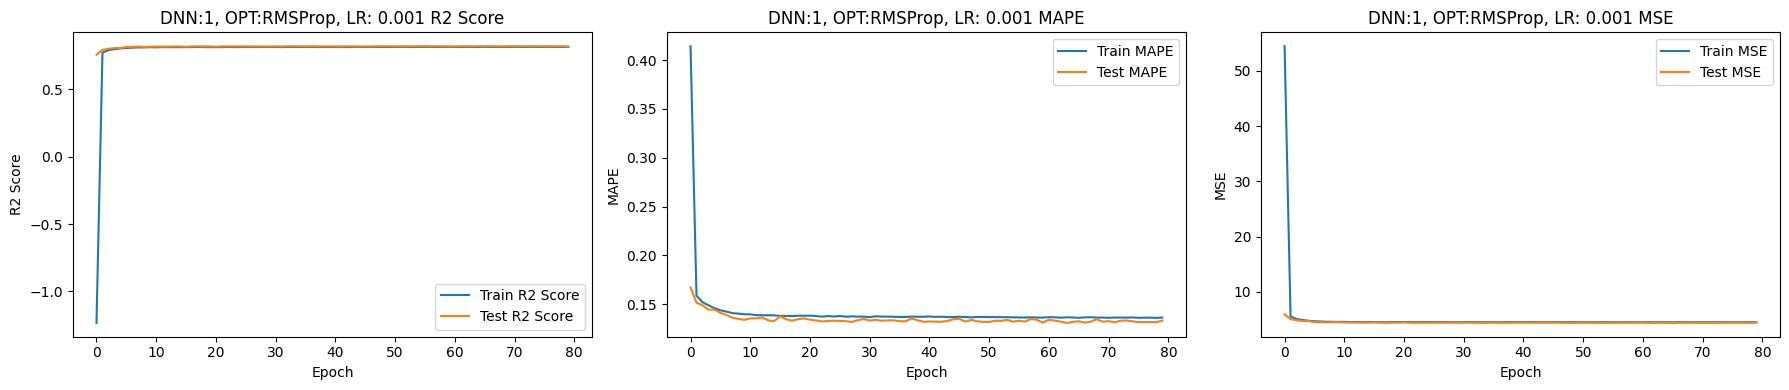

Epoch 1/80, 	    R2 Score (Train): 0.8132,    MAPE (Train): 0.1286,  	    MSE (Train): 4.5541
Epoch 1/80, 	    R2 Score (Validation): 0.4429,    MAPE (Validation): 0.2293, 	 MSE    (Validation): 13.6436
Epoch 6/80, 	    R2 Score (Train): 0.9385,    MAPE (Train): 0.0826,  	    MSE (Train): 1.4994
Epoch 11/80, 	    R2 Score (Train): 0.9402,    MAPE (Train): 0.0833,  	    MSE (Train): 1.4588
Epoch 11/80, 	    R2 Score (Validation): 0.9246,    MAPE (Validation): 0.0988, 	 MSE    (Validation): 1.8461
Epoch 16/80, 	    R2 Score (Train): 0.9402,    MAPE (Train): 0.0830,  	    MSE (Train): 1.4572
Epoch 21/80, 	    R2 Score (Train): 0.9419,    MAPE (Train): 0.0811,  	    MSE (Train): 1.4155
Epoch 21/80, 	    R2 Score (Validation): 0.9346,    MAPE (Validation): 0.0837, 	 MSE    (Validation): 1.6005
Epoch 26/80, 	    R2 Score (Train): 0.9428,    MAPE (Train): 0.0808,  	    MSE (Train): 1.3937
Epoch 31/80, 	    R2 Score (Train): 0.9441,    MAPE (Train): 0.0791,  	    MSE (Train): 1.3633
Epoch 31/8

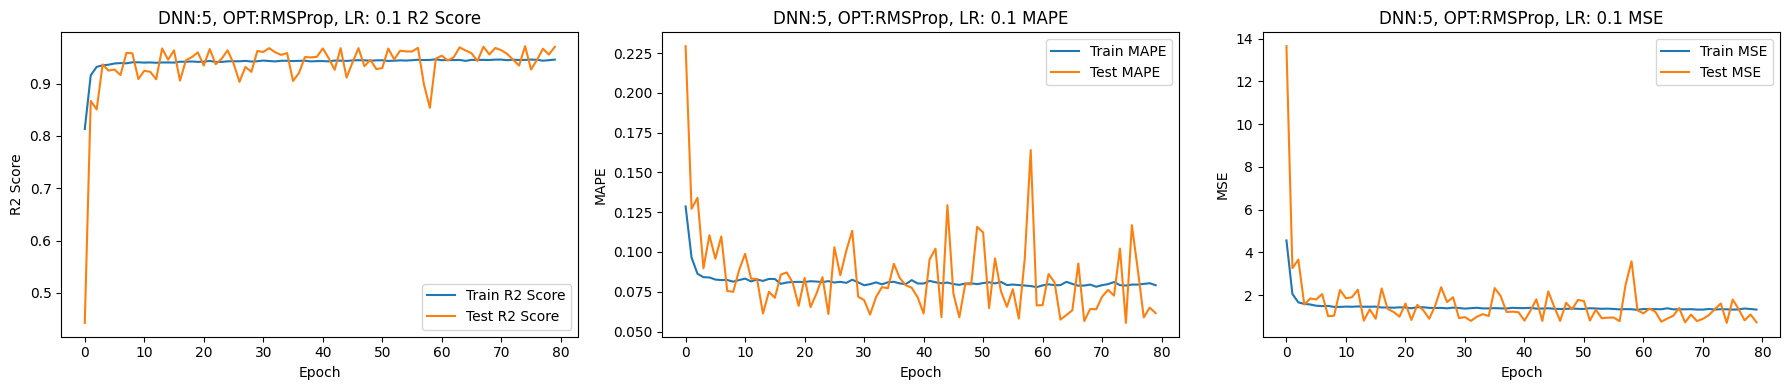

Epoch 1/80, 	    R2 Score (Train): 0.8576,    MAPE (Train): 0.1053,  	    MSE (Train): 3.4700
Epoch 1/80, 	    R2 Score (Validation): 0.9363,    MAPE (Validation): 0.0882, 	 MSE    (Validation): 1.5607
Epoch 6/80, 	    R2 Score (Train): 0.9454,    MAPE (Train): 0.0794,  	    MSE (Train): 1.3306
Epoch 11/80, 	    R2 Score (Train): 0.9497,    MAPE (Train): 0.0756,  	    MSE (Train): 1.2266
Epoch 11/80, 	    R2 Score (Validation): 0.9648,    MAPE (Validation): 0.0652, 	 MSE    (Validation): 0.8608
Epoch 16/80, 	    R2 Score (Train): 0.9524,    MAPE (Train): 0.0734,  	    MSE (Train): 1.1613
Epoch 21/80, 	    R2 Score (Train): 0.9531,    MAPE (Train): 0.0727,  	    MSE (Train): 1.1441
Epoch 21/80, 	    R2 Score (Validation): 0.9674,    MAPE (Validation): 0.0638, 	 MSE    (Validation): 0.7978
Epoch 26/80, 	    R2 Score (Train): 0.9549,    MAPE (Train): 0.0714,  	    MSE (Train): 1.1002
Epoch 31/80, 	    R2 Score (Train): 0.9547,    MAPE (Train): 0.0716,  	    MSE (Train): 1.1053
Epoch 31/80

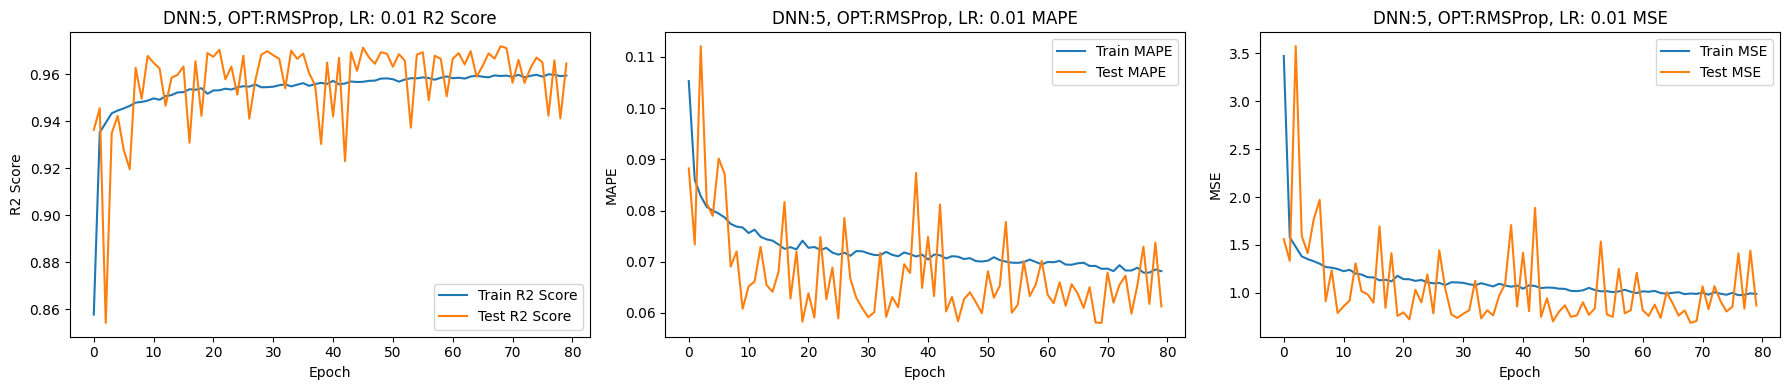

Epoch 1/80, 	    R2 Score (Train): -0.8750,    MAPE (Train): 0.3725,  	    MSE (Train): 45.7014
Epoch 1/80, 	    R2 Score (Validation): 0.9376,    MAPE (Validation): 0.0817, 	 MSE    (Validation): 1.5285
Epoch 6/80, 	    R2 Score (Train): 0.9476,    MAPE (Train): 0.0780,  	    MSE (Train): 1.2765
Epoch 11/80, 	    R2 Score (Train): 0.9497,    MAPE (Train): 0.0761,  	    MSE (Train): 1.2252
Epoch 11/80, 	    R2 Score (Validation): 0.9671,    MAPE (Validation): 0.0596, 	 MSE    (Validation): 0.8049
Epoch 16/80, 	    R2 Score (Train): 0.9521,    MAPE (Train): 0.0744,  	    MSE (Train): 1.1670
Epoch 21/80, 	    R2 Score (Train): 0.9536,    MAPE (Train): 0.0731,  	    MSE (Train): 1.1314
Epoch 21/80, 	    R2 Score (Validation): 0.9683,    MAPE (Validation): 0.0601, 	 MSE    (Validation): 0.7756
Epoch 26/80, 	    R2 Score (Train): 0.9537,    MAPE (Train): 0.0729,  	    MSE (Train): 1.1282
Epoch 31/80, 	    R2 Score (Train): 0.9553,    MAPE (Train): 0.0718,  	    MSE (Train): 1.0903
Epoch 31/

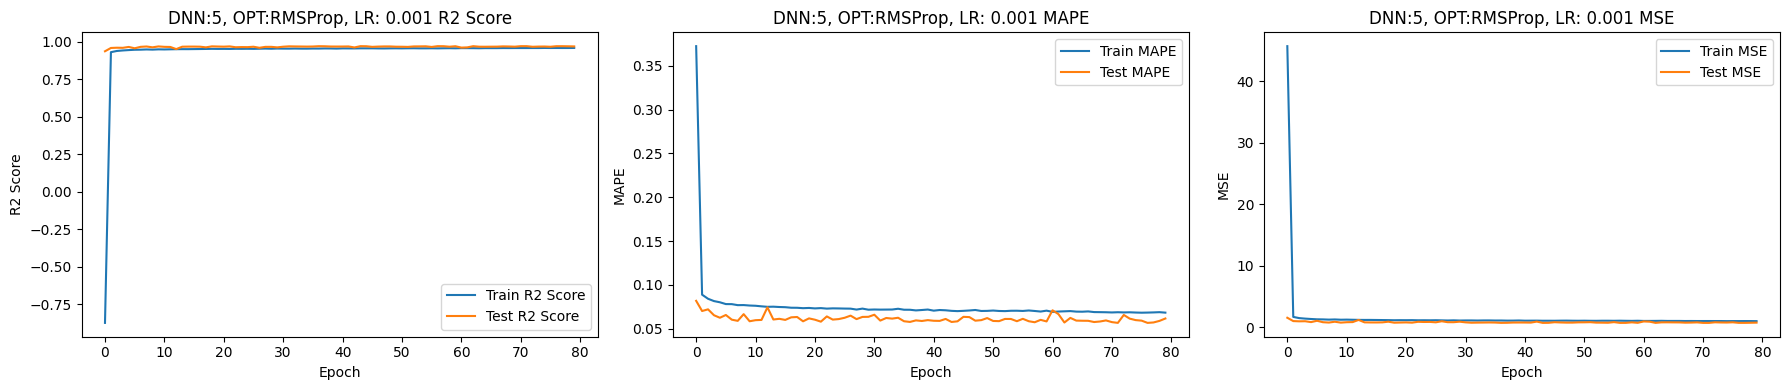

Epoch 1/80, 	    R2 Score (Train): 0.7677,    MAPE (Train): 0.1470,  	    MSE (Train): 5.6625
Epoch 1/80, 	    R2 Score (Validation): 0.2908,    MAPE (Validation): 0.2601, 	 MSE    (Validation): 17.3675
Epoch 6/80, 	    R2 Score (Train): 0.9377,    MAPE (Train): 0.0845,  	    MSE (Train): 1.5182
Epoch 11/80, 	    R2 Score (Train): 0.9422,    MAPE (Train): 0.0803,  	    MSE (Train): 1.4080
Epoch 11/80, 	    R2 Score (Validation): 0.9331,    MAPE (Validation): 0.0865, 	 MSE    (Validation): 1.6392
Epoch 16/80, 	    R2 Score (Train): 0.9418,    MAPE (Train): 0.0812,  	    MSE (Train): 1.4175
Epoch 21/80, 	    R2 Score (Train): 0.9438,    MAPE (Train): 0.0808,  	    MSE (Train): 1.3701
Epoch 21/80, 	    R2 Score (Validation): 0.8959,    MAPE (Validation): 0.1288, 	 MSE    (Validation): 2.5487
Epoch 26/80, 	    R2 Score (Train): 0.9451,    MAPE (Train): 0.0792,  	    MSE (Train): 1.3382
Epoch 31/80, 	    R2 Score (Train): 0.9441,    MAPE (Train): 0.0799,  	    MSE (Train): 1.3633
Epoch 31/8

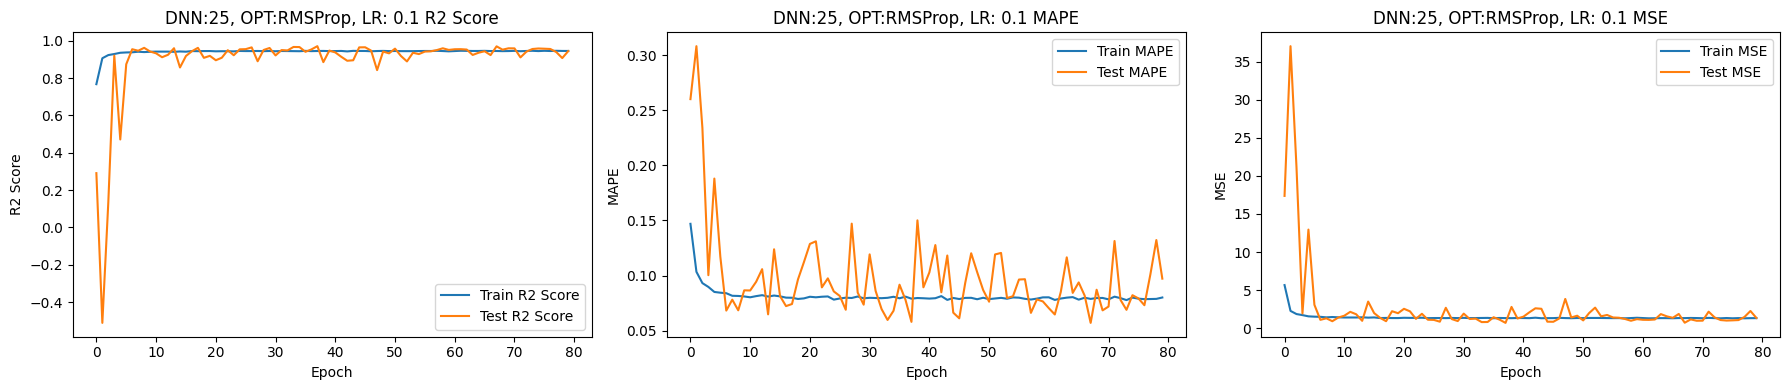

Epoch 1/80, 	    R2 Score (Train): 0.5798,    MAPE (Train): 0.2113,  	    MSE (Train): 10.2424
Epoch 1/80, 	    R2 Score (Validation): 0.7923,    MAPE (Validation): 0.1455, 	 MSE    (Validation): 5.0872
Epoch 6/80, 	    R2 Score (Train): 0.9392,    MAPE (Train): 0.0860,  	    MSE (Train): 1.4823
Epoch 11/80, 	    R2 Score (Train): 0.9460,    MAPE (Train): 0.0819,  	    MSE (Train): 1.3171
Epoch 11/80, 	    R2 Score (Validation): 0.7857,    MAPE (Validation): 0.1955, 	 MSE    (Validation): 5.2467
Epoch 16/80, 	    R2 Score (Train): 0.9488,    MAPE (Train): 0.0777,  	    MSE (Train): 1.2483
Epoch 21/80, 	    R2 Score (Train): 0.9506,    MAPE (Train): 0.0759,  	    MSE (Train): 1.2030
Epoch 21/80, 	    R2 Score (Validation): 0.9453,    MAPE (Validation): 0.0824, 	 MSE    (Validation): 1.3389
Epoch 26/80, 	    R2 Score (Train): 0.9513,    MAPE (Train): 0.0753,  	    MSE (Train): 1.1871
Epoch 31/80, 	    R2 Score (Train): 0.9517,    MAPE (Train): 0.0752,  	    MSE (Train): 1.1783
Epoch 31/8

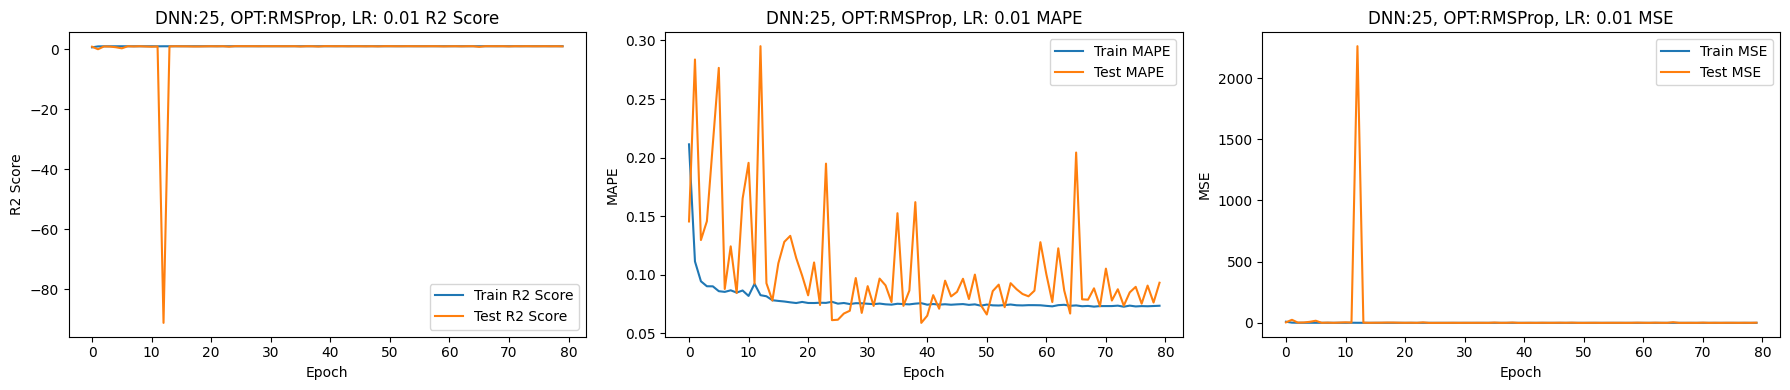

Epoch 1/80, 	    R2 Score (Train): -1.3900,    MAPE (Train): 0.4429,  	    MSE (Train): 58.2524
Epoch 1/80, 	    R2 Score (Validation): 0.3768,    MAPE (Validation): 0.2987, 	 MSE    (Validation): 15.2614
Epoch 6/80, 	    R2 Score (Train): 0.9076,    MAPE (Train): 0.1068,  	    MSE (Train): 2.2533
Epoch 11/80, 	    R2 Score (Train): 0.9294,    MAPE (Train): 0.0920,  	    MSE (Train): 1.7204
Epoch 11/80, 	    R2 Score (Validation): 0.8529,    MAPE (Validation): 0.1151, 	 MSE    (Validation): 3.6019
Epoch 16/80, 	    R2 Score (Train): 0.9343,    MAPE (Train): 0.0900,  	    MSE (Train): 1.6013
Epoch 21/80, 	    R2 Score (Train): 0.9343,    MAPE (Train): 0.0882,  	    MSE (Train): 1.6009
Epoch 21/80, 	    R2 Score (Validation): 0.9279,    MAPE (Validation): 0.0825, 	 MSE    (Validation): 1.7657
Epoch 26/80, 	    R2 Score (Train): 0.9407,    MAPE (Train): 0.0844,  	    MSE (Train): 1.4451
Epoch 31/80, 	    R2 Score (Train): 0.9444,    MAPE (Train): 0.0812,  	    MSE (Train): 1.3556
Epoch 31

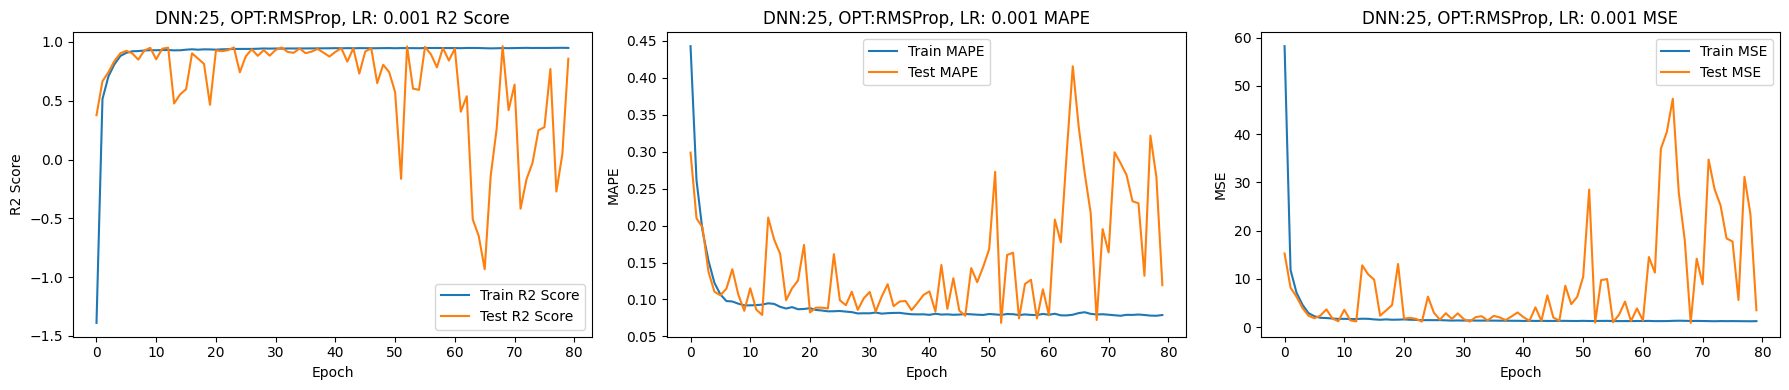

Epoch 1/80, 	    R2 Score (Train): 0.7337,    MAPE (Train): 0.1554,  	    MSE (Train): 6.4901
Epoch 1/80, 	    R2 Score (Validation): 0.7780,    MAPE (Validation): 0.1490, 	 MSE    (Validation): 5.4369
Epoch 6/80, 	    R2 Score (Train): 0.8599,    MAPE (Train): 0.1270,  	    MSE (Train): 3.4157
Epoch 11/80, 	    R2 Score (Train): 0.8742,    MAPE (Train): 0.1201,  	    MSE (Train): 3.0671
Epoch 11/80, 	    R2 Score (Validation): 0.7973,    MAPE (Validation): 0.1662, 	 MSE    (Validation): 4.9645
Epoch 16/80, 	    R2 Score (Train): 0.8823,    MAPE (Train): 0.1175,  	    MSE (Train): 2.8690
Epoch 21/80, 	    R2 Score (Train): 0.8803,    MAPE (Train): 0.1186,  	    MSE (Train): 2.9172
Epoch 21/80, 	    R2 Score (Validation): 0.9041,    MAPE (Validation): 0.1045, 	 MSE    (Validation): 2.3476
Epoch 26/80, 	    R2 Score (Train): 0.8846,    MAPE (Train): 0.1168,  	    MSE (Train): 2.8126
Epoch 31/80, 	    R2 Score (Train): 0.8822,    MAPE (Train): 0.1166,  	    MSE (Train): 2.8722
Epoch 31/80

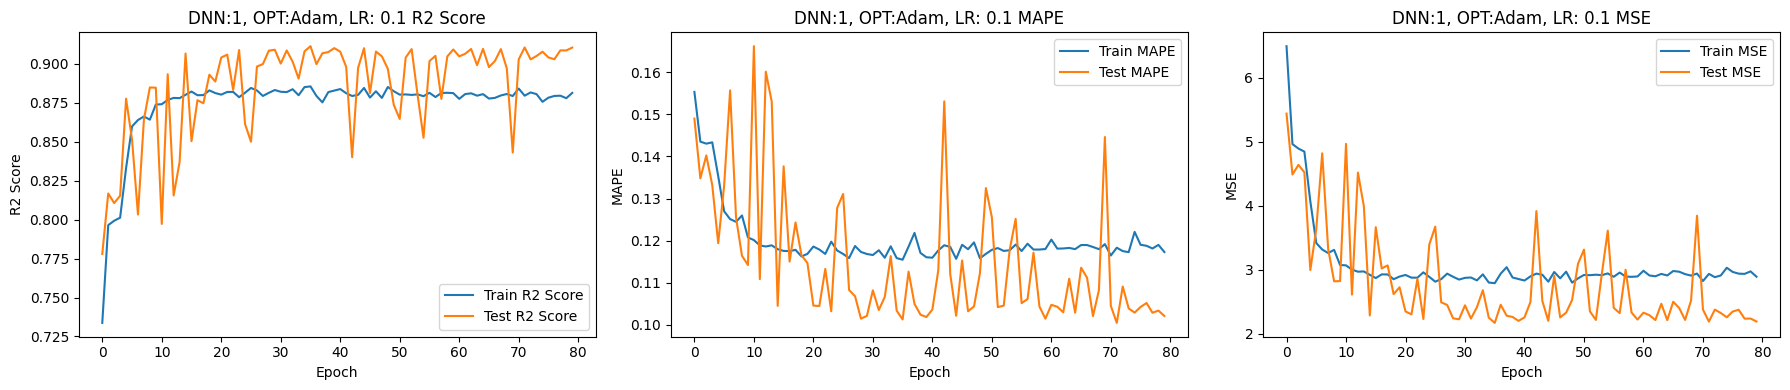

Epoch 1/80, 	    R2 Score (Train): 0.4422,    MAPE (Train): 0.1966,  	    MSE (Train): 13.5959
Epoch 1/80, 	    R2 Score (Validation): 0.7953,    MAPE (Validation): 0.1451, 	 MSE    (Validation): 5.0123
Epoch 6/80, 	    R2 Score (Train): 0.8178,    MAPE (Train): 0.1365,  	    MSE (Train): 4.4402
Epoch 11/80, 	    R2 Score (Train): 0.8993,    MAPE (Train): 0.1075,  	    MSE (Train): 2.4535
Epoch 11/80, 	    R2 Score (Validation): 0.9146,    MAPE (Validation): 0.1004, 	 MSE    (Validation): 2.0918
Epoch 16/80, 	    R2 Score (Train): 0.9382,    MAPE (Train): 0.0831,  	    MSE (Train): 1.5066
Epoch 21/80, 	    R2 Score (Train): 0.9378,    MAPE (Train): 0.0830,  	    MSE (Train): 1.5151
Epoch 21/80, 	    R2 Score (Validation): 0.9530,    MAPE (Validation): 0.0723, 	 MSE    (Validation): 1.1505
Epoch 26/80, 	    R2 Score (Train): 0.9386,    MAPE (Train): 0.0826,  	    MSE (Train): 1.4953
Epoch 31/80, 	    R2 Score (Train): 0.9384,    MAPE (Train): 0.0825,  	    MSE (Train): 1.5006
Epoch 31/8

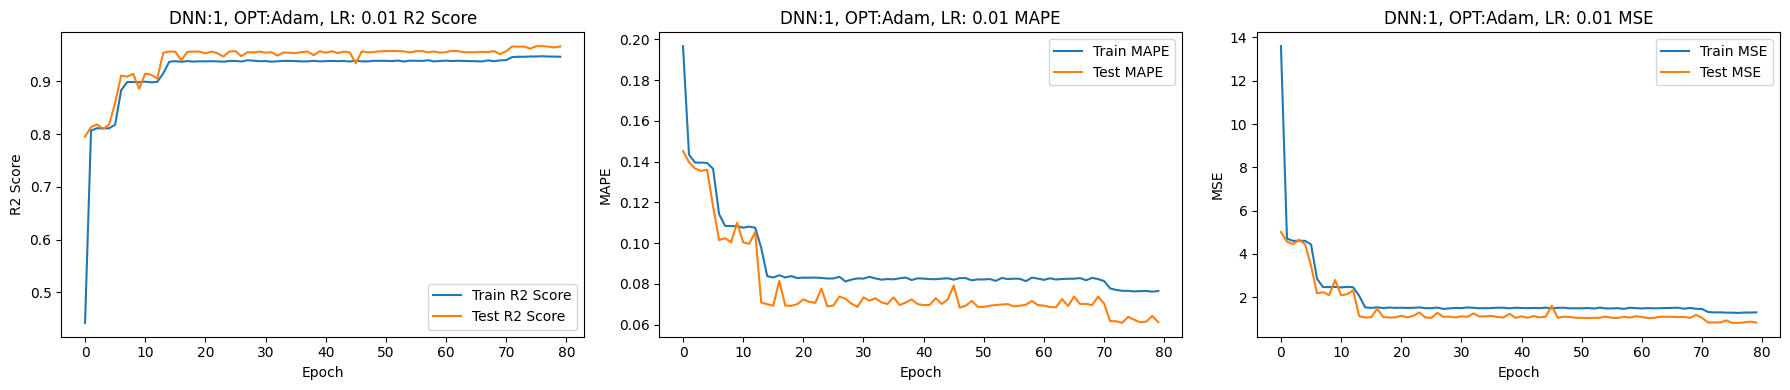

Epoch 1/80, 	    R2 Score (Train): -2.1372,    MAPE (Train): 0.5022,  	    MSE (Train): 76.4647
Epoch 1/80, 	    R2 Score (Validation): 0.7480,    MAPE (Validation): 0.1659, 	 MSE    (Validation): 6.1710
Epoch 6/80, 	    R2 Score (Train): 0.7952,    MAPE (Train): 0.1506,  	    MSE (Train): 4.9926
Epoch 11/80, 	    R2 Score (Train): 0.8122,    MAPE (Train): 0.1407,  	    MSE (Train): 4.5782
Epoch 11/80, 	    R2 Score (Validation): 0.8177,    MAPE (Validation): 0.1384, 	 MSE    (Validation): 4.4636
Epoch 16/80, 	    R2 Score (Train): 0.8135,    MAPE (Train): 0.1386,  	    MSE (Train): 4.5450
Epoch 21/80, 	    R2 Score (Train): 0.8148,    MAPE (Train): 0.1376,  	    MSE (Train): 4.5149
Epoch 21/80, 	    R2 Score (Validation): 0.8199,    MAPE (Validation): 0.1339, 	 MSE    (Validation): 4.4115
Epoch 26/80, 	    R2 Score (Train): 0.8152,    MAPE (Train): 0.1376,  	    MSE (Train): 4.5033
Epoch 31/80, 	    R2 Score (Train): 0.8151,    MAPE (Train): 0.1374,  	    MSE (Train): 4.5057
Epoch 31/

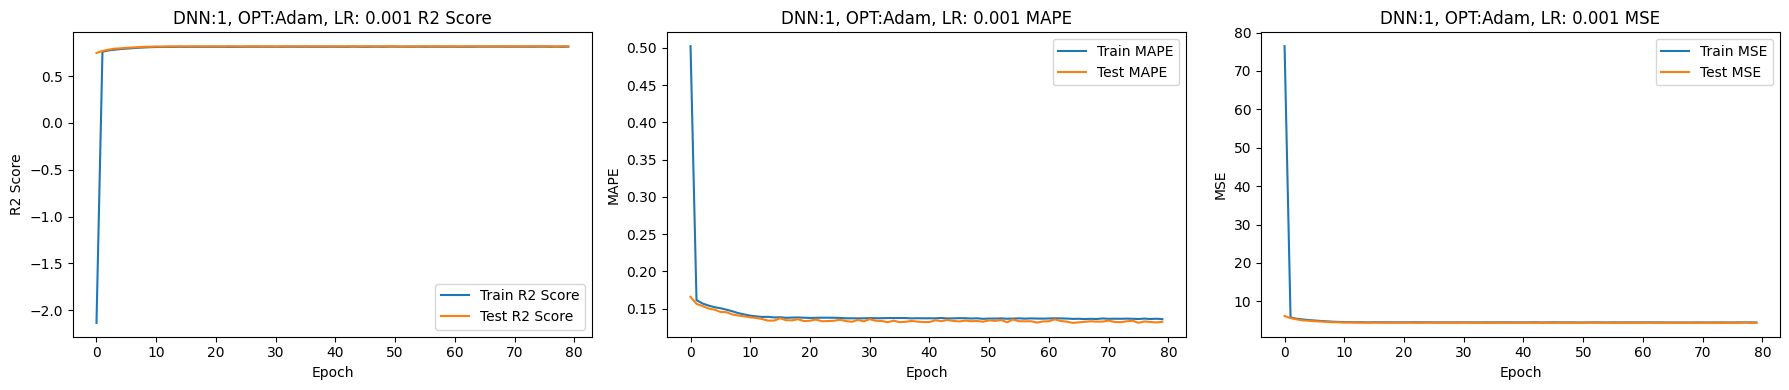

Epoch 1/80, 	    R2 Score (Train): 0.8534,    MAPE (Train): 0.1067,  	    MSE (Train): 3.5729
Epoch 1/80, 	    R2 Score (Validation): 0.9477,    MAPE (Validation): 0.0834, 	 MSE    (Validation): 1.2807
Epoch 6/80, 	    R2 Score (Train): 0.9330,    MAPE (Train): 0.0882,  	    MSE (Train): 1.6328
Epoch 11/80, 	    R2 Score (Train): 0.9430,    MAPE (Train): 0.0841,  	    MSE (Train): 1.3898
Epoch 11/80, 	    R2 Score (Validation): 0.9546,    MAPE (Validation): 0.0822, 	 MSE    (Validation): 1.1126
Epoch 16/80, 	    R2 Score (Train): 0.9471,    MAPE (Train): 0.0768,  	    MSE (Train): 1.2903
Epoch 21/80, 	    R2 Score (Train): 0.9487,    MAPE (Train): 0.0774,  	    MSE (Train): 1.2495
Epoch 21/80, 	    R2 Score (Validation): 0.9541,    MAPE (Validation): 0.0720, 	 MSE    (Validation): 1.1237
Epoch 26/80, 	    R2 Score (Train): 0.9483,    MAPE (Train): 0.0766,  	    MSE (Train): 1.2591
Epoch 31/80, 	    R2 Score (Train): 0.9492,    MAPE (Train): 0.0749,  	    MSE (Train): 1.2375
Epoch 31/80

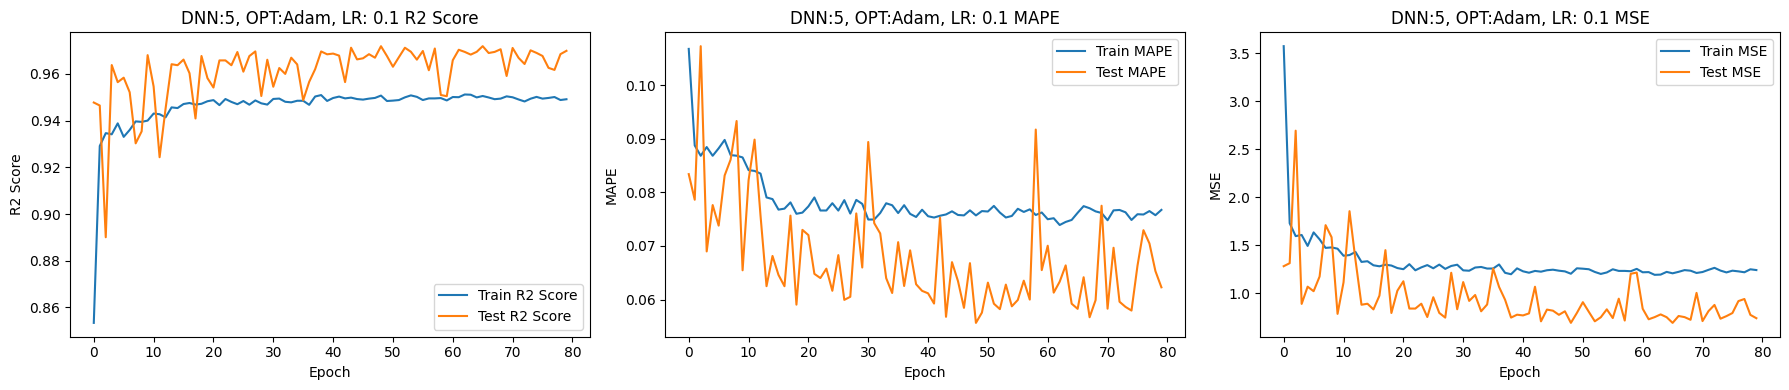

Epoch 1/80, 	    R2 Score (Train): 0.5540,    MAPE (Train): 0.1396,  	    MSE (Train): 10.8709
Epoch 1/80, 	    R2 Score (Validation): 0.9325,    MAPE (Validation): 0.0801, 	 MSE    (Validation): 1.6520
Epoch 6/80, 	    R2 Score (Train): 0.9464,    MAPE (Train): 0.0782,  	    MSE (Train): 1.3061
Epoch 11/80, 	    R2 Score (Train): 0.9503,    MAPE (Train): 0.0759,  	    MSE (Train): 1.2113
Epoch 11/80, 	    R2 Score (Validation): 0.9663,    MAPE (Validation): 0.0616, 	 MSE    (Validation): 0.8249
Epoch 16/80, 	    R2 Score (Train): 0.9521,    MAPE (Train): 0.0739,  	    MSE (Train): 1.1673
Epoch 21/80, 	    R2 Score (Train): 0.9532,    MAPE (Train): 0.0724,  	    MSE (Train): 1.1404
Epoch 21/80, 	    R2 Score (Validation): 0.9690,    MAPE (Validation): 0.0626, 	 MSE    (Validation): 0.7589
Epoch 26/80, 	    R2 Score (Train): 0.9542,    MAPE (Train): 0.0722,  	    MSE (Train): 1.1174
Epoch 31/80, 	    R2 Score (Train): 0.9543,    MAPE (Train): 0.0721,  	    MSE (Train): 1.1146
Epoch 31/8

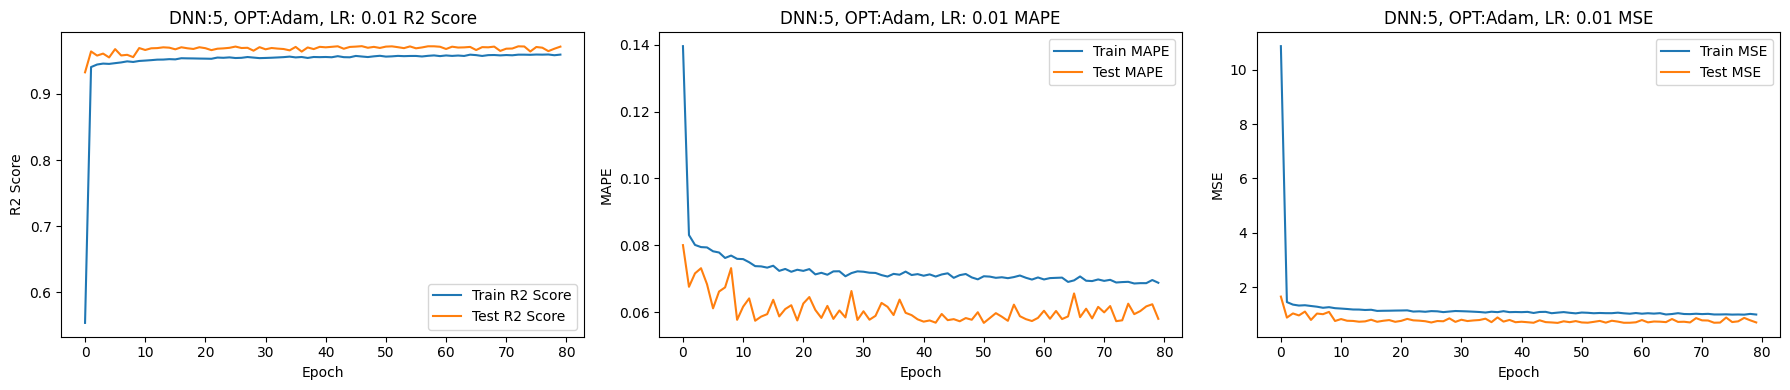

Epoch 1/80, 	    R2 Score (Train): -2.0602,    MAPE (Train): 0.4961,  	    MSE (Train): 74.5890
Epoch 1/80, 	    R2 Score (Validation): 0.9350,    MAPE (Validation): 0.0882, 	 MSE    (Validation): 1.5926
Epoch 6/80, 	    R2 Score (Train): 0.9466,    MAPE (Train): 0.0787,  	    MSE (Train): 1.3010
Epoch 11/80, 	    R2 Score (Train): 0.9495,    MAPE (Train): 0.0760,  	    MSE (Train): 1.2301
Epoch 11/80, 	    R2 Score (Validation): 0.9643,    MAPE (Validation): 0.0617, 	 MSE    (Validation): 0.8753
Epoch 16/80, 	    R2 Score (Train): 0.9516,    MAPE (Train): 0.0750,  	    MSE (Train): 1.1794
Epoch 21/80, 	    R2 Score (Train): 0.9539,    MAPE (Train): 0.0732,  	    MSE (Train): 1.1226
Epoch 21/80, 	    R2 Score (Validation): 0.9697,    MAPE (Validation): 0.0591, 	 MSE    (Validation): 0.7424
Epoch 26/80, 	    R2 Score (Train): 0.9540,    MAPE (Train): 0.0733,  	    MSE (Train): 1.1201
Epoch 31/80, 	    R2 Score (Train): 0.9551,    MAPE (Train): 0.0718,  	    MSE (Train): 1.0933
Epoch 31/

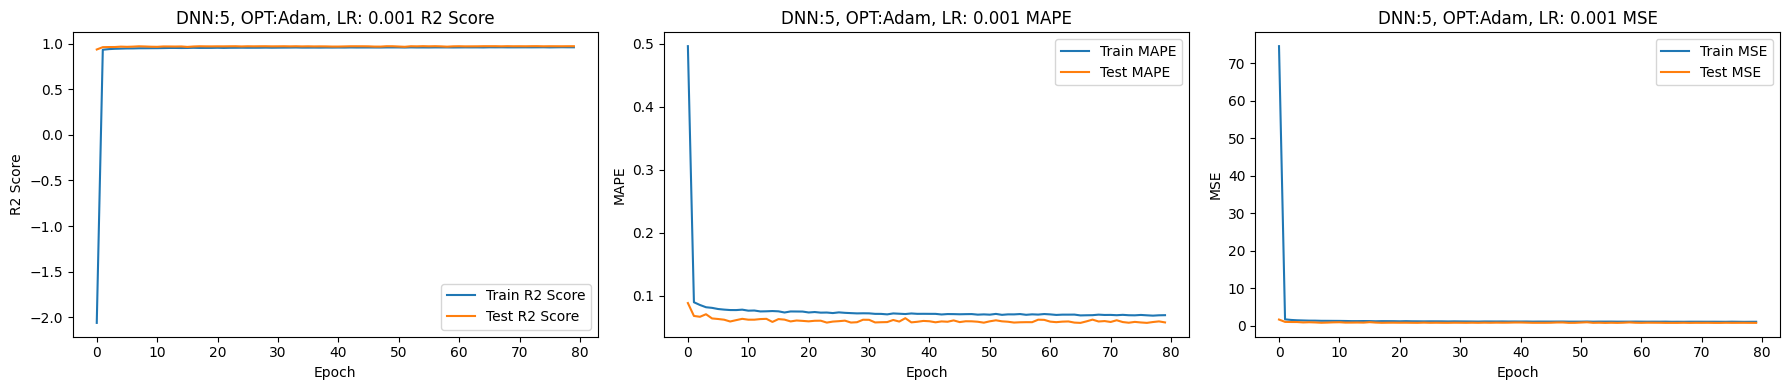

Epoch 1/80, 	    R2 Score (Train): 0.5426,    MAPE (Train): 0.2238,  	    MSE (Train): 11.1480
Epoch 1/80, 	    R2 Score (Validation): 0.8246,    MAPE (Validation): 0.1314, 	 MSE    (Validation): 4.2952
Epoch 6/80, 	    R2 Score (Train): 0.9291,    MAPE (Train): 0.0935,  	    MSE (Train): 1.7286
Epoch 11/80, 	    R2 Score (Train): 0.9389,    MAPE (Train): 0.0868,  	    MSE (Train): 1.4883
Epoch 11/80, 	    R2 Score (Validation): 0.9335,    MAPE (Validation): 0.0954, 	 MSE    (Validation): 1.6285
Epoch 16/80, 	    R2 Score (Train): 0.9418,    MAPE (Train): 0.0845,  	    MSE (Train): 1.4187
Epoch 21/80, 	    R2 Score (Train): 0.9466,    MAPE (Train): 0.0808,  	    MSE (Train): 1.3009
Epoch 21/80, 	    R2 Score (Validation): 0.9503,    MAPE (Validation): 0.0863, 	 MSE    (Validation): 1.2160
Epoch 26/80, 	    R2 Score (Train): 0.9455,    MAPE (Train): 0.0813,  	    MSE (Train): 1.3278
Epoch 31/80, 	    R2 Score (Train): 0.9483,    MAPE (Train): 0.0798,  	    MSE (Train): 1.2592
Epoch 31/8

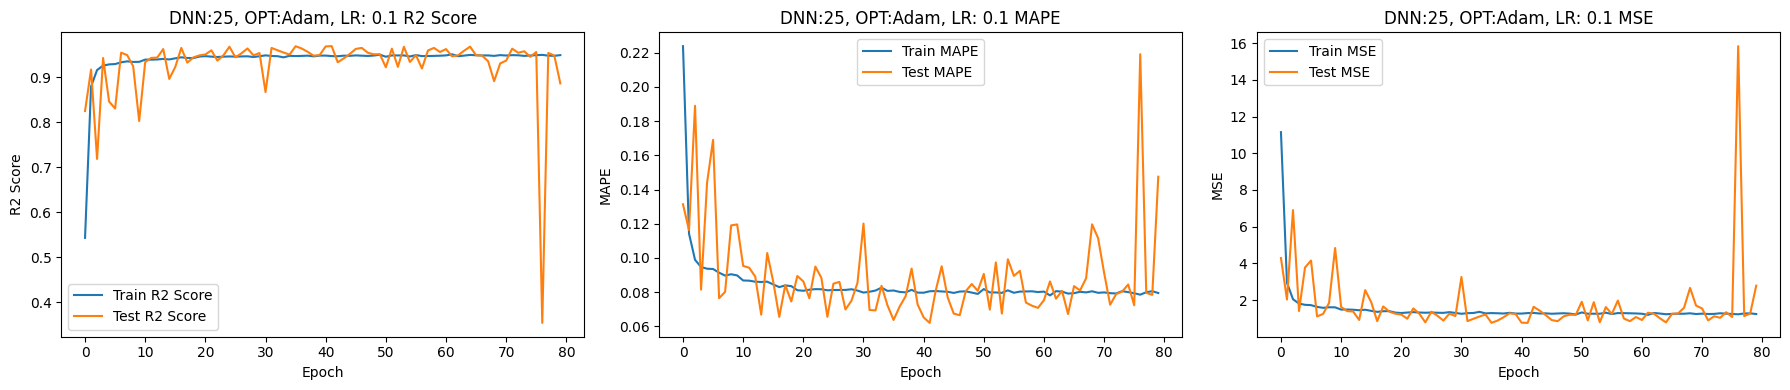

Epoch 1/80, 	    R2 Score (Train): 0.1266,    MAPE (Train): 0.2991,  	    MSE (Train): 21.2889
Epoch 1/80, 	    R2 Score (Validation): 0.7820,    MAPE (Validation): 0.1577, 	 MSE    (Validation): 5.3386
Epoch 6/80, 	    R2 Score (Train): 0.9362,    MAPE (Train): 0.0860,  	    MSE (Train): 1.5544
Epoch 11/80, 	    R2 Score (Train): 0.9387,    MAPE (Train): 0.0834,  	    MSE (Train): 1.4952
Epoch 11/80, 	    R2 Score (Validation): 0.9575,    MAPE (Validation): 0.0673, 	 MSE    (Validation): 1.0403
Epoch 16/80, 	    R2 Score (Train): 0.9401,    MAPE (Train): 0.0843,  	    MSE (Train): 1.4604
Epoch 21/80, 	    R2 Score (Train): 0.9408,    MAPE (Train): 0.0844,  	    MSE (Train): 1.4418
Epoch 21/80, 	    R2 Score (Validation): -0.4883,    MAPE (Validation): 0.3731, 	 MSE    (Validation): 36.4466
Epoch 26/80, 	    R2 Score (Train): 0.9476,    MAPE (Train): 0.0791,  	    MSE (Train): 1.2784
Epoch 31/80, 	    R2 Score (Train): 0.9475,    MAPE (Train): 0.0797,  	    MSE (Train): 1.2804
Epoch 31

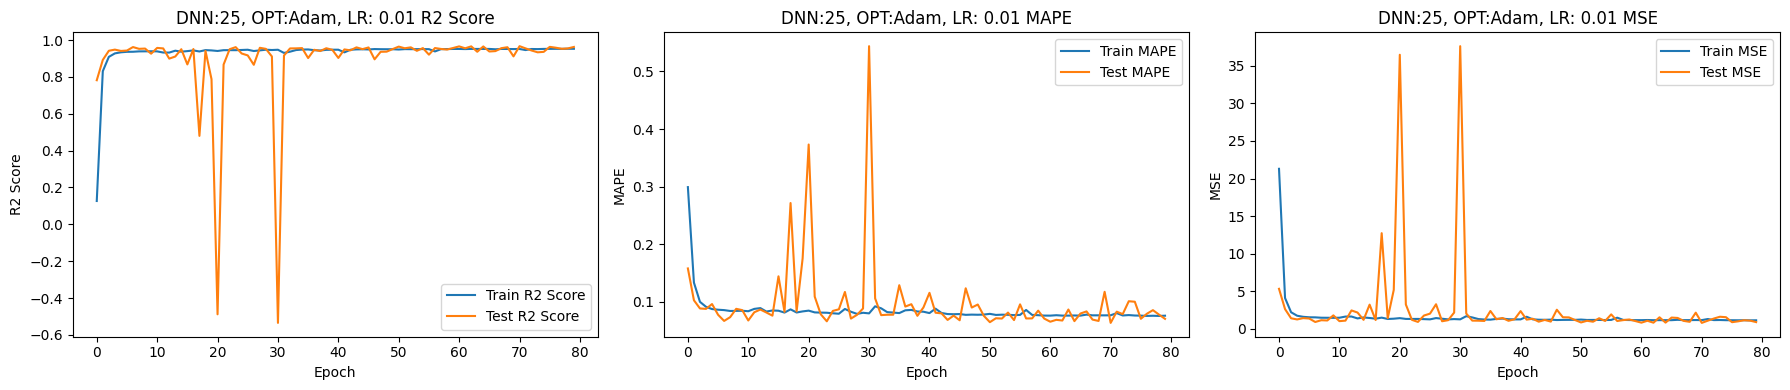

Epoch 1/80, 	    R2 Score (Train): -2.5759,    MAPE (Train): 0.5332,  	    MSE (Train): 87.1570
Epoch 1/80, 	    R2 Score (Validation): 0.3342,    MAPE (Validation): 0.2976, 	 MSE    (Validation): 16.3034
Epoch 6/80, 	    R2 Score (Train): 0.8239,    MAPE (Train): 0.1419,  	    MSE (Train): 4.2925


In [ ]:
optimizers = ['SGD', 'RMSProp', 'Adam']
for opt in optimizers:
    for layer_size in layers_sizes:
        for learning_rate in learning_rates:
            model = DNN(
                input_size=input_layer_size,
                hidden_size=neyrons_amount,
                output_size=output_layer_size,
                num_layers=layer_size
            )
            if opt == 'SGD':
                optimizer = optim.SGD(
                    model.parameters(),
                    lr=learning_rate
                )
            elif opt == 'RMSProp':
                optimizer = optim.RMSprop(
                    model.parameters(),
                    lr=learning_rate
                )
            else:
                optimizer = optim.Adam(
                    model.parameters(),
                    lr=learning_rate
                )
            criterion = nn.MSELoss()

            r2_train_scores, r2_val_scores,\
             mape_train_scores, mape_val_scores, mse_train_losses, mse_val_losses,\
            predictions_train, predictions_val = train_validate_model_dnn(model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

            fig, axs = plt.subplots(1, 3, figsize=(18, 4))

            axs[0].plot(r2_train_scores, label='Train R2 Score')
            axs[0].plot(r2_val_scores, label='Test R2 Score')
            axs[0].set_xlabel('Epoch')
            axs[0].set_ylabel('R2 Score')
            axs[0].set_title(f'DNN:{layer_size}, OPT:{opt}, LR: {learning_rate} R2 Score')
            axs[0].legend()

            axs[1].plot(mape_train_scores, label='Train MAPE')
            axs[1].plot(mape_val_scores, label='Test MAPE')
            axs[1].set_xlabel('Epoch')
            axs[1].set_ylabel('MAPE')
            axs[1].set_title(f'DNN:{layer_size}, OPT:{opt}, LR: {learning_rate} MAPE')
            axs[1].legend()

            axs[2].plot(mse_train_losses, label='Train MSE')
            axs[2].plot(mse_val_losses, label='Test MSE')
            axs[2].set_xlabel('Epoch')
            axs[2].set_ylabel('MSE')
            axs[2].set_title(f'DNN:{layer_size}, OPT:{opt}, LR: {learning_rate} MSE')
            axs[2].legend()

            plt.tight_layout()
            plt.show()

Оскільки під час виводу останнього графіка в нотбуці трапилася помилка ГПУ, запустимо код для DNN 25 Adam LR=0.001 окремо від усіх

Epoch 1/80, 	    R2 Score (Train): -2.2122,    MAPE (Train): 0.4953,  	    MSE (Train): 78.2943
Epoch 1/80, 	    R2 Score (Validation): 0.4144,    MAPE (Validation): 0.2682, 	 MSE    (Validation): 14.3402
Epoch 6/80, 	    R2 Score (Train): 0.8805,    MAPE (Train): 0.1138,  	    MSE (Train): 2.9117
Epoch 11/80, 	    R2 Score (Train): 0.9368,    MAPE (Train): 0.0868,  	    MSE (Train): 1.5414
Epoch 11/80, 	    R2 Score (Validation): 0.9494,    MAPE (Validation): 0.0807, 	 MSE    (Validation): 1.2390
Epoch 16/80, 	    R2 Score (Train): 0.9401,    MAPE (Train): 0.0840,  	    MSE (Train): 1.4591
Epoch 21/80, 	    R2 Score (Train): 0.9467,    MAPE (Train): 0.0795,  	    MSE (Train): 1.2981
Epoch 21/80, 	    R2 Score (Validation): 0.9650,    MAPE (Validation): 0.0676, 	 MSE    (Validation): 0.8581
Epoch 26/80, 	    R2 Score (Train): 0.9484,    MAPE (Train): 0.0781,  	    MSE (Train): 1.2578
Epoch 31/80, 	    R2 Score (Train): 0.9494,    MAPE (Train): 0.0770,  	    MSE (Train): 1.2327
Epoch 31

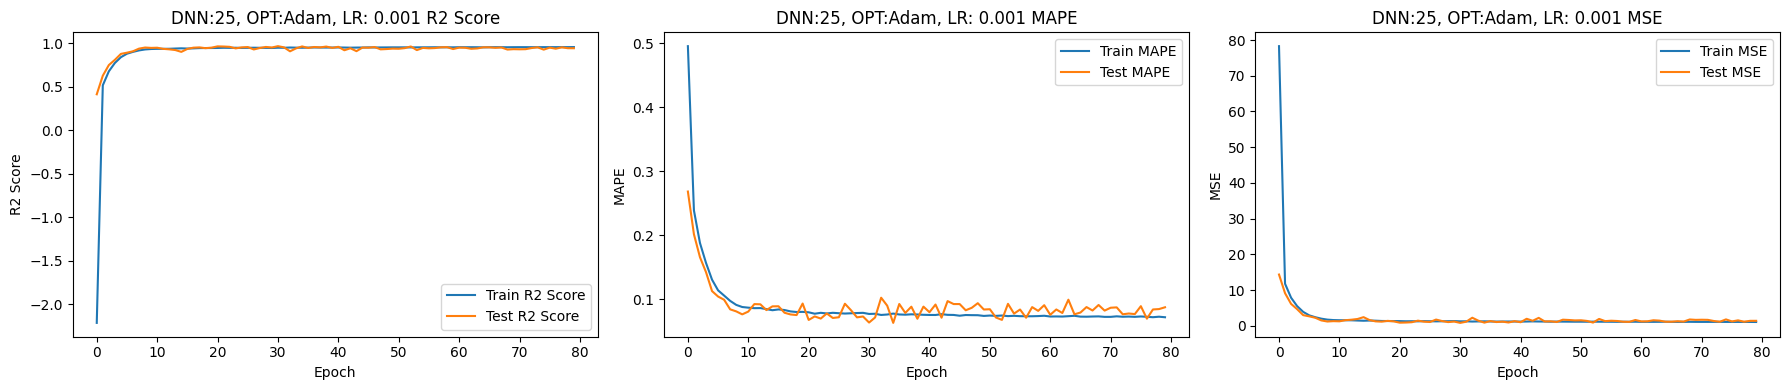

In [17]:
optimizers = ['Adam']
for opt in optimizers:
    model = DNN(
        input_size=input_layer_size,
        hidden_size=neyrons_amount,
        output_size=output_layer_size,
        num_layers=25
    )
    if opt == 'SGD':
        optimizer = optim.SGD(
            model.parameters(),
            lr=learning_rate
        )
    elif opt == 'RMSProp':
        optimizer = optim.RMSprop(
            model.parameters(),
            lr=learning_rate
        )
    else:
        optimizer = optim.Adam(
            model.parameters(),
            lr=0.001
        )
    criterion = nn.MSELoss()

    r2_train_scores, r2_val_scores,\
      mape_train_scores, mape_val_scores, mse_train_losses, mse_val_losses,\
    predictions_train, predictions_val = train_validate_model_dnn(model, optimizer, criterion, train_loader, test_loader, epochs=epochs)

    fig, axs = plt.subplots(1, 3, figsize=(18, 4))

    axs[0].plot(r2_train_scores, label='Train R2 Score')
    axs[0].plot(r2_val_scores, label='Test R2 Score')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('R2 Score')
    axs[0].set_title('DNN:25, OPT:Adam, LR: 0.001 R2 Score')
    axs[0].legend()

    axs[1].plot(mape_train_scores, label='Train MAPE')
    axs[1].plot(mape_val_scores, label='Test MAPE')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('MAPE')
    axs[1].set_title('DNN:25, OPT:Adam, LR: 0.001 MAPE')
    axs[1].legend()

    axs[2].plot(mse_train_losses, label='Train MSE')
    axs[2].plot(mse_val_losses, label='Test MSE')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('MSE')
    axs[2].set_title('DNN:25, OPT:Adam, LR: 0.001 MSE')
    axs[2].legend()

    plt.tight_layout()
    plt.show()

# 3. Висновки з отриманих результатів, та порівняння моделей лінійної регресії та нейронних мереж
Порівнюючи результати R2 оцінки і інших метрик можимо сказати з впевненістю, що в даній регресійній задачі кращі результати має DNN адже в результаті роботи вона має точність прогнозування на валідаційних і навчальних даних в найкращих випадках ззначення R2 = 0.94, а в свою чергу лінійна регресія мала R2=0.73, що обумовлено тим, що дані в даному датасеті розподілені не лінійно, і їх важко описати прямою.


1.   У даній лабораторній роботі найкращі результати показала модель нейронної мережі для DNN з 5ма шарами на оптимізаторі Adam з Learning Rate 0.001, вона найкращі значення на валідаційному датасеті із всіх, а саме 0.94, а також відхилення між валідаційними і тренувальними даними було мінімальним, що свідчить про те що оверфітингу для даної моделі небуло на навчальних даних. Найгірші в свою чергу результати мала модель DNN на 25 шарів з оптимізатором RMSProp та Learning Rate = 0.01, так і валідаційні і тренувальні дані мали значення R2 від'ємним що свідчило про те що модель дуже погано натринована. В свою чергу задовільні середні і в рази кращі за лінійну регресію параметри мала DNN з одним шаром оптимізатором SGD та значення Learning Rate = 0.001 для R2 оцінкии, а саме 0.81. Причиною даних результатів є значення гіперпараметрів, а найбільше значення learning rate та кількості шарів і нейронів в них, адже в більшості мереж наведених вище на графіках спостерігалося велике перенавчання і як наслідок погане значення на валідаційних даних це було пов'язане із занадто великою кількість шарів в мережі через що результати мережа просто запам'ятовувала, а в свою чергу на мережах з одним шаром ситуації з перенавчанням майже не бувало, але в свою чергу в більшості випадків такі мережі мали реузльтати прогнозування значень ніж навіть лінійна регресія, саме тому оптимальним значенням є саме DNN з 5ма параметрами, та відповідно learning rate 0.001, оскільки оптимізація значень градієнтів відбувалася з високою точністю через backpropagation.

2. Якщо порівнювати вплив оптимізаторів на результати передбачення то найкращі результати показав оптимізатор Adam, вслід за ним стохастичний градієнтний спуск (SGD), та найгірші показники мав RMSProp

3. При збільшенні значення learning rate точність передбачення ставала гіршою оскільки при покращенні значень ваг оптимізатори робили більші 'стрибки' за рахунок чого градієнтний спуск міг пропустити нові оптимальні значення ваг, а в свою чергу при збільшенні learning rate значення передбачення покращувалися, але модель звісно тратила більше часу на навчання

4. При занадто малій кількості шарів значення передбачення погіршувалися, але зарахунок цього модель швидше навчалася, а в свою чергу при занадто великій кількості шарів значення покращувалися, але довше навчалися і крім того не виключено можливість перенавчання при занадто великій кількості шарів.

5. Розподілу даних в функції make_friedman1 є нелінійним за визначенням, оскільки так написано в документації до функції, що означає що їх неможливо повноцінно описати прямою з лінійної регресії, звідки і витікає що максимальна точність прогнозування лінійної регресії зіставила лише R2 = 0.73, проте у свою чергу нейронні мережі можуть добре працювати і з нелінійним розподілом даних, за рахунок чого була досягнута така висока точність прогнозування при 5ти шарах DNN, R2=0.94  


# Виконав:
# студент **Орлянський Максим**
# Група:
# КН-317

# Прийняв:
# асистент **Гурбич О.В.**